# Unemployment and Pet Adoption Rates in Austin, TX

# Overview

In this project we initially set out to explore the relationship between unemployment and adoption rates in Austin, TX from 2013 to 2019. We determined that there was no correlation between change in unemployment and change in adoption counts. We noticed that age seemed to be correlated with adoptions, since many young pets were adopted. Ultimately we found age to be a much better predictor of a pet being adopted than the unemployment rate in Austin, TX.

# Names

- Matthew Morgan
- Nicolas La Polla
- Nathan Price
- Joshua Suh
- Noemi Yepez

# Research Question

When people are facing financial hardship, do they tend to adopt more pets? What characteristics of pets make them more adoptable?

Is there a relationship between unemployment rates and pet adoption in Austin, Texas?

## Background and Prior Work


### Why is this question of interest to your group?
Having a pet is very common among American households. Pet owners, such as ourselves, love pets very much and want to do all they can to provide and find homes for them. We are curious to see if outside events influence people’s perspectives on pets. More specifically we want to know if willingness to adopt a pet changes with tragedies like economic hardships. While this is our primary focus, we also hope to investigate what characteristics are deemed more desirable when it comes to a pet being adopted.

### Hypothesis and what is already known
Our hypothesis is that spikes in unemployment, will drive higher adoption numbers. We have seen anecdotes and news articles suggesting that people are turning to pets during the present pandemic (1). Some statistics have shown that there is a downward trend in the number of euthanized pets and pets entering shelters in the US since 2011 and that it can possibly correlate to increased adoption rates (2). We want to further substantiate such a correlation and attempt to explain it further. Although there has been some examination of adoption over time, it hasn’t been largely linked to the economic trends we want to investigate.

Additionally, we believe that age will be a significant factor in whether a pet gets adopted. Studies exist that show a correlation between physical characteristics and whether a pet gets adopted or transferred, euthanized, etc. (3). We believe we can further investigate and substantiate this claim with our data.

### Why it’s important
The issue of drastic changes in the number of adoptions may cause a devastating impact on the animals in rescue shelters/animal pounds. Adopting pets is essential in decreasing the effects of overpopulation in pet shelters and decreasing the number of pets that have to be euthanized due to such overcrowding. However, when the adoption rates drop drastically in a short span of time, the shelter won’t be able to support the new influx of stray animals that will arrive at their facility. Knowing when and how pet adoption numbers increase or decrease could help with allocating resources to pet shelters according to changing adoption rates. Shelters could make more efficient use of resources and consequently keep shelter euthanization rates low, ensuring humane treatment.

### References:

1. https://www.wired.com/story/coronavirus-pet-adoption-boom/
2. https://www.aspca.org/animal-homelessness/shelter-intake-and-surrender/pet-statistics
3. https://priceonomics.com/what-kinds-of-pets-get-adopted/

# Hypothesis


Our overall hypothesis is that upward trends in unemployment rates cause more pets to be adopted in Austin, TX. Of those adopted, we believe the main factor contributing to their adoption is their age.

# Dataset(s)

**Dataset 1 - Austin TX Animal Center Outcomes**
- Link to the dataset: https://data.austintexas.gov/widgets/9t4d-g238
- Number of observations: ~100000
- Each observation of this dateset represents an animal leaving the Austin Animal Center. The datasets covers all releases from the Austin Animal Center from October 1st, 2013 to present. 
- The dataset provides many variables about each animal outcome, including: 
  - Unique Animal ID
  - Animal Name
  - Time of Outcome
  - Month/Year of Outcome
  - Animal Date of Birth
  - Outcome Type
  - Outcome Subtype
  - Animal Type
  - Sex upon Outcome
  - Age upon Outcome
  - Breed
  - Color
- For our research question, we chose to focus on primary factors that may influence adoptions, including: 
  - Date of Outcome
  - Age upon Outcome
  - Animal Type
  - Sex upon Outcome

**Dataset 2 - Austin TX Unemployment**
- Link to the dataset: https://data.bls.gov/timeseries/LAUMT481242000000003?amp%253bdata_tool=XGtable&output_view=data&include_graphs=true
- Number of observations: 30
- Each cell represents the unemployment rate for a given year and month. We are interested in the unemployment rate for the range of 2013-present because that is the time covered by our Austin Outcomes dataset. 

The Austin outcomes dataset is our primary dataset for this project because it includes many possible predictors of adoption. However, we are also interested in how economic factors may influence adoption and would like to include local unemployment data as a predictor as well. 

# Setup

In [1]:
#Essentials
import pandas as pd
import numpy as np

#Graphing
import seaborn as sns
import matplotlib.pyplot as plt

#Statistics
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as sm1
import scipy.stats as stats

# Data Cleaning

## Unemployment Dataset
The cleaning for this dataset is minimal. We only drop the data for the 2020 year because it is incomplete. We will only be using data up to 2019 because the entire year is complete for both datasets.

In [2]:
df = pd.read_csv('./Unemployment.csv')
df = df.set_index("Year")

# We only need drop the data for the 2020 year
df = df.drop(df.tail(1).index)

## Outcomes Dataset
For this dataset, we remove duplicate and unnecessary columns.
- "Name" is not necessary for our analysis "Animal ID" provides a unique identifier for each animal
- "Date of Birth" provides duplicate information to the "Age upon outcome" column
- "MonthYear" provides duplicate information to "DateTime"
- "Outcome Subtype" does not concern us as we are only concerned with the primary categories of outcome (adoption, transfer, return to owner, euthanasia)
- "Color" is not necessary for our analysis

In [3]:
outcomes = pd.read_csv('./Austin_Animal_Center_Outcomes.csv')

# Drop columns unnecessary for our analysis
outcomes = outcomes.drop(["Name", "Date of Birth", "MonthYear", "Outcome Subtype", "Color"], axis=1)

## Missing Values
Relative to the total number of observations (~100000), the number of missing values is insignificant. We will disregard them in our analysis.

In [4]:
print(outcomes['DateTime'].isnull().sum()) # 0
print(outcomes['Animal ID'].isnull().sum()) # 0
print(outcomes['Outcome Type'].isnull().sum()) # 8
print(outcomes['Animal Type'].isnull().sum()) # 0
print(outcomes['Sex upon Outcome'].isnull().sum()) # 4
print(outcomes['Age upon Outcome'].isnull().sum()) # 52

0
0
8
0
4
52


## Standardize Age Upon Outcome
In order to use Age Upon Outcome we need to standardize it by removing the handful of missing or negative values and converting all values to floating point for numerical analysis. This is important in distinguishing the difference between puppies (< 1 year of age) in our analyses. 

In [5]:
# Check different values given for Age upom Outcome
outcomes['Age upon Outcome'] = outcomes['Age upon Outcome'].astype(str)
outcomes['Age upon Outcome'].unique()

array(['2 years', '1 year', '4 months', '6 days', '2 months', '7 years',
       '2 days', '3 weeks', '9 months', '4 weeks', '2 weeks', '3 months',
       '9 years', '10 years', '6 months', '8 years', '3 years',
       '7 months', '6 years', '4 years', '1 month', '12 years', '5 years',
       '1 weeks', '5 months', '5 days', '15 years', '11 months',
       '10 months', '4 days', '16 years', '1 day', '8 months', '11 years',
       '13 years', '1 week', '14 years', '3 days', '0 years', 'nan',
       '5 weeks', '17 years', '18 years', '20 years', '22 years',
       '19 years', '24 years', '25 years', '21 years', '-1 years',
       '-3 years'], dtype=object)

In [6]:
# Standardize Age upon Outcome
def standardize_age(string):
    string = string.strip()
    if 'years' in string:
        string = string.replace('years', '')
        string = string.strip()
        string = string
    elif 'year' in string:
        string = string.replace('year', '')
        string = string.strip()
        string = string
    elif 'months' in string:
        string = string.replace('months', '')
        string = string.strip()
        string = float(string) / 12
    elif 'month' in string:
        string = string.replace('month', '')
        string = string.strip()
        string = float(string) / 12
    elif 'weeks' in string:
        string = string.replace('weeks', '')
        string = string.strip()
        string = float(string) / 52
    elif 'week' in string:
        string = string.replace('week', '')
        string = string.strip()
        string = float(string) / 52
    elif 'days' in string:
        string = string.replace('days', '')
        string = string.strip()
        string = float(string) / 365
    elif 'day' in string:
        string = string.replace('day', '')
        string = string.strip()
        string = float(string) / 365
    try:
        return float(string)
    except:
        return np.nan

In [7]:
# apply standardize function
outcomes['Age upon Outcome'] = outcomes['Age upon Outcome'].apply(standardize_age)

# remove the handful of negative, 0, or nan values
outcomes = outcomes.drop(labels=outcomes[(outcomes['Age upon Outcome'] == -3.0) | (outcomes['Age upon Outcome'] == -1.0) | (outcomes['Age upon Outcome'].isna()) |  (outcomes['Age upon Outcome'] == 0.0)].index)

In [8]:
# check updated dataframe
outcomes

,Animal ID,DateTime,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed
0,A794011,05/08/2019 06:20:00 PM,Rto-Adopt,Cat,Neutered Male,2.000000,Domestic Shorthair Mix
1,A776359,07/18/2018 04:02:00 PM,Adoption,Dog,Neutered Male,1.000000,Chihuahua Shorthair Mix
2,A720371,02/13/2016 05:59:00 PM,Adoption,Dog,Neutered Male,0.333333,Anatol Shepherd/Labrador Retriever
3,A674754,03/18/2014 11:47:00 AM,Transfer,Cat,Intact Male,0.016438,Domestic Shorthair Mix
4,A689724,10/18/2014 06:52:00 PM,Adoption,Cat,Neutered Male,0.166667,Domestic Shorthair Mix
...,...,...,...,...,...,...,...
117837,A817990,05/30/2020 08:54:00 AM,Disposal,Dog,Unknown,2.000000,Chihuahua Shorthair
117838,A817989,05/30/2020 08:56:00 AM,Disposal,Cat,Unknown,0.166667,Domestic Shorthair
117839,A807962,04/04/2020 12:00:00 AM,Adoption,Dog,Spayed Female,1.000000,Labrador Retriever Mix
117840,A817631,05/30/2020 10:38:00 AM,Transfer,Dog,Intact Male,2.000000,German Shepherd


## Remove Unnecessary Animal Types

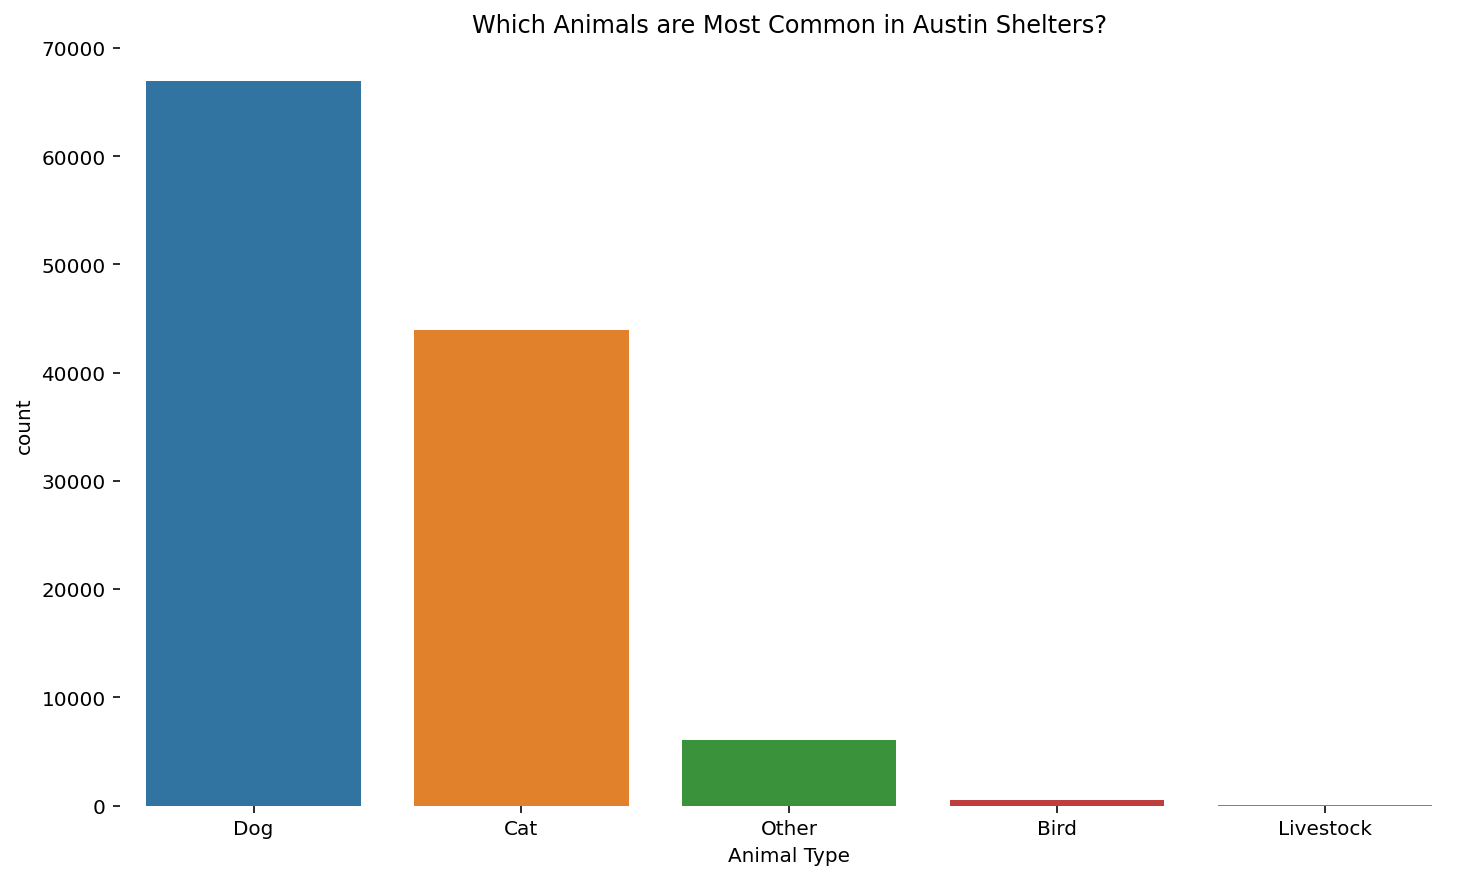

In [9]:
# bar chart of animal types
typeOrder = outcomes['Animal Type'].value_counts(ascending=False).index
sns.countplot(x="Animal Type", data=outcomes, order=typeOrder).set_title('Which Animals are Most Common in Austin Shelters?')
sns.despine(top=True, right=True, left=True, bottom=True)

We can see that the dataset is dominated by dogs and cats which is perfect for our purposes of examining pet adoption. We will focus on only the data for dogs/cats in our analyses.

In [10]:
# Since we are mainly interested in analyzing cats and dogs, we will drop all other observations
otherAnimals = outcomes[(outcomes['Animal Type'] != 'Cat') & (outcomes['Animal Type'] != 'Dog')].index
outcomes = outcomes.drop(labels=otherAnimals)
outcomes['Animal Type'].value_counts()

Dog    66969
Cat    43987
Name: Animal Type, dtype: int64

## Duplicate Animals
We can see that roughly 11% of the animals in the dataset have been in shelters more than once. We decided to make a graph to determine whether removing duplicate animals will have any major effect on the trends over time.

In [11]:
# We can see that some Animals appear more than once
(len(outcomes['Animal ID']) - outcomes['Animal ID'].nunique()) / len(outcomes) 

0.11224269079635171

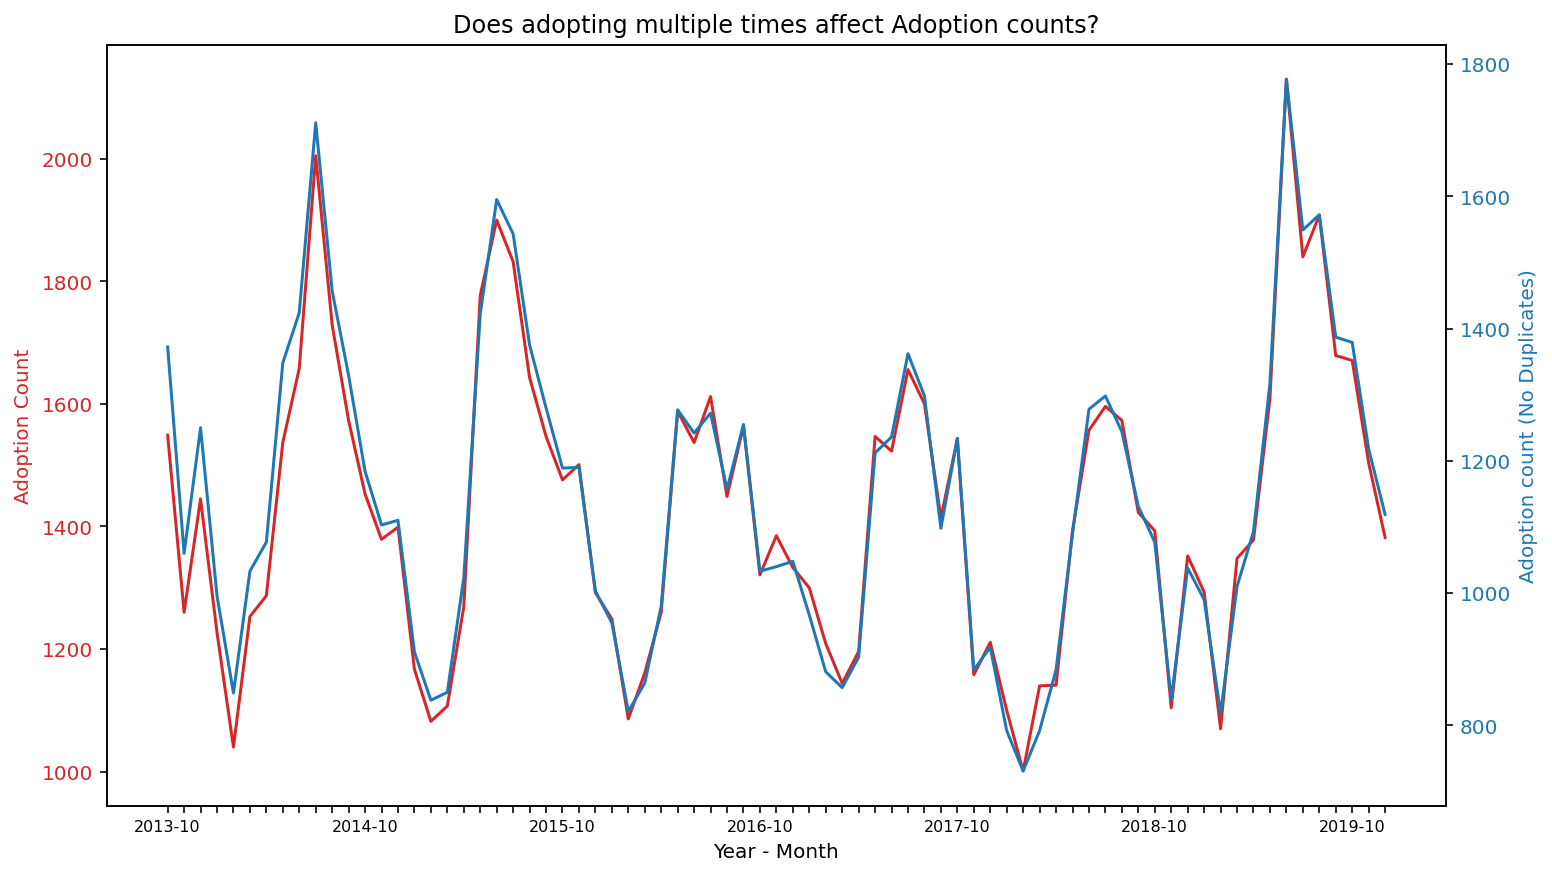

In [12]:
#Check if duplicates have major impact on graph
#Create Dataframe that has no duplicates
NoDupesDF = outcomes.copy()
NoDupesDF.drop_duplicates(subset= "Animal ID", keep=False, inplace = True)

#Save a dataframe that has duplicates
newOutcomesDF = outcomes
newOutcomesDF['DateTime'] = pd.to_datetime(newOutcomesDF.DateTime)
newOutcomesGroup = newOutcomesDF['DateTime'].groupby(newOutcomesDF.DateTime.dt.to_period("M")).agg('count')

#Sort Dates and create x axis for graph
NoDupesDF['DateTime'] = pd.to_datetime(NoDupesDF.DateTime)
NoDupesGroup = NoDupesDF['DateTime'].groupby(NoDupesDF.DateTime.dt.to_period("M")).agg('count')
fullxaxis = newOutcomesGroup.index.to_series().astype(str) #x axis for both
xaxis = fullxaxis[:75]

#Create graph and plot adoption count w/ duplicate
fig, dax1 = plt.subplots()
color = 'tab:red' 
dax1.set_xlabel('Year - Month')
dax1.set_ylabel('Adoption Count', color=color)
dax1.plot(xaxis, newOutcomesGroup.to_numpy()[:75], color=color)
dax1.tick_params(axis='y', labelcolor=color)
dax1.set_title("Does adopting multiple times affect Adoption counts?")

#Create graph and plot adoption count w/o duplicate
dax2 = dax1.twinx() #(1)
color = 'tab:blue'
dax2.set_ylabel('Adoption count (No Duplicates)', color=color) #(2)
dax2.plot(xaxis, NoDupesGroup.to_numpy()[:75], color=color) #change dax1 to dax2 (or vicee versa) and (un)comment 1,2, and 3 to see how graphs look with separate y axis to better compare shape
dax2.tick_params(axis='y', labelcolor=color) #(3)

# Keeps every 12th label
n = 12
[l.set_visible(False) for (i,l) in enumerate(dax1.xaxis.get_ticklabels()) if i % n != 0]
dax1.set_xticklabels(xaxis, fontsize=8)
plt.show()

The graph shows no major shape differences between duplicate adoptions and no duplicate adoptions. The reduced adoption count with the graph itself can be explained by the lesser amount of data NoDupesDf has due to having duplicates removed. It is likely that duplicates do not have a major impact in adoptions.

# Data Analysis

## Exploratory Data Analysis

For our analyses we need to see differences between monthly numbers of dog adoptions versus cat adoptions.

In [13]:
# Dogs only dataframe
dogsDF = outcomes.loc[outcomes['Animal Type'] == "Dog"]
dogsDF = dogsDF.loc[outcomes['Outcome Type'] == "Adoption"]

#Standardize and sort by time
dogsDF['DateTime'] = pd.to_datetime(dogsDF.DateTime)
dogsDF = dogsDF.sort_values(by=['DateTime'])
dogsDF

,Animal ID,DateTime,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed
52422,A659834,2013-10-01 09:31:00,Adoption,Dog,Neutered Male,0.166667,Labrador Retriever Mix
24594,A663572,2013-10-01 11:42:00,Adoption,Dog,Spayed Female,3.000000,Anatol Shepherd Mix
93673,A662104,2013-10-01 15:47:00,Adoption,Dog,Spayed Female,3.000000,Labrador Retriever Mix
110479,A663827,2013-10-01 17:02:00,Adoption,Dog,Neutered Male,0.666667,Labrador Retriever Mix
783,A664032,2013-10-01 17:18:00,Adoption,Dog,Spayed Female,0.166667,German Shepherd Mix
...,...,...,...,...,...,...,...
117817,A701495,2020-05-29 07:04:00,Adoption,Dog,Spayed Female,10.000000,Pit Bull Mix
117824,A817495,2020-05-29 14:37:00,Adoption,Dog,Neutered Male,1.000000,Pit Bull
117826,A817512,2020-05-29 14:38:00,Adoption,Dog,Spayed Female,2.000000,Pointer
117823,A817567,2020-05-29 14:40:00,Adoption,Dog,Neutered Male,0.500000,Labrador Retriever Mix


In [14]:
# Get count of dog adoptions for month and year
dogsDFGroup = dogsDF['DateTime'].groupby(dogsDF.DateTime.dt.to_period("M")).agg('count')
dogsDFGroup

DateTime
2013-10    365
2013-11    324
2013-12    405
2014-01    359
2014-02    340
          ... 
2020-01    434
2020-02    412
2020-03    289
2020-04    132
2020-05    138
Freq: M, Name: DateTime, Length: 80, dtype: int64

In [39]:
# Cat adoptions only dataframe
# 15804 adoptions/ 35518 total
catsDF = outcomes.loc[outcomes['Animal Type'] == "Cat"]
catsDF = catsDF.loc[outcomes['Outcome Type'] == "Adoption"]
catsDF['DateTime'] = pd.to_datetime(catsDF.DateTime)
catsDF = catsDF.sort_values(by=['DateTime'])
catsDF

,Animal ID,DateTime,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Age_10
8003,A661795,2013-10-01 11:53:00,Adoption,Cat,Spayed Female,0.500000,Domestic Shorthair Mix,-0.301030
45309,A656894,2013-10-01 11:53:00,Adoption,Cat,Neutered Male,0.416667,Domestic Shorthair Mix,-0.380211
79843,A660634,2013-10-01 16:17:00,Adoption,Cat,Spayed Female,0.166667,Domestic Shorthair,-0.778151
44074,A663920,2013-10-01 16:53:00,Adoption,Cat,Spayed Female,0.166667,Snowshoe Mix,-0.778151
17096,A664111,2013-10-01 18:54:00,Adoption,Cat,Spayed Female,0.500000,Domestic Shorthair Mix,-0.301030
...,...,...,...,...,...,...,...,...
117759,A814960,2020-05-26 13:56:00,Adoption,Cat,Spayed Female,1.000000,Domestic Shorthair,0.000000
117758,A813706,2020-05-26 13:59:00,Adoption,Cat,Neutered Male,1.000000,Domestic Shorthair,0.000000
117763,A813989,2020-05-26 14:05:00,Adoption,Cat,Neutered Male,0.750000,Domestic Shorthair,-0.124939
117793,A810991,2020-05-27 16:37:00,Adoption,Cat,Spayed Female,1.000000,Siamese Mix,0.000000


In [16]:
# Get count for month and year
catsDFGroup = catsDF['DateTime'].groupby(catsDF.DateTime.dt.to_period("M")).agg('count')
catsDFGroup

DateTime
2013-10    241
2013-11    227
2013-12    278
2014-01    159
2014-02     97
          ... 
2020-01    208
2020-02    187
2020-03     85
2020-04     53
2020-05     45
Freq: M, Name: DateTime, Length: 80, dtype: int64

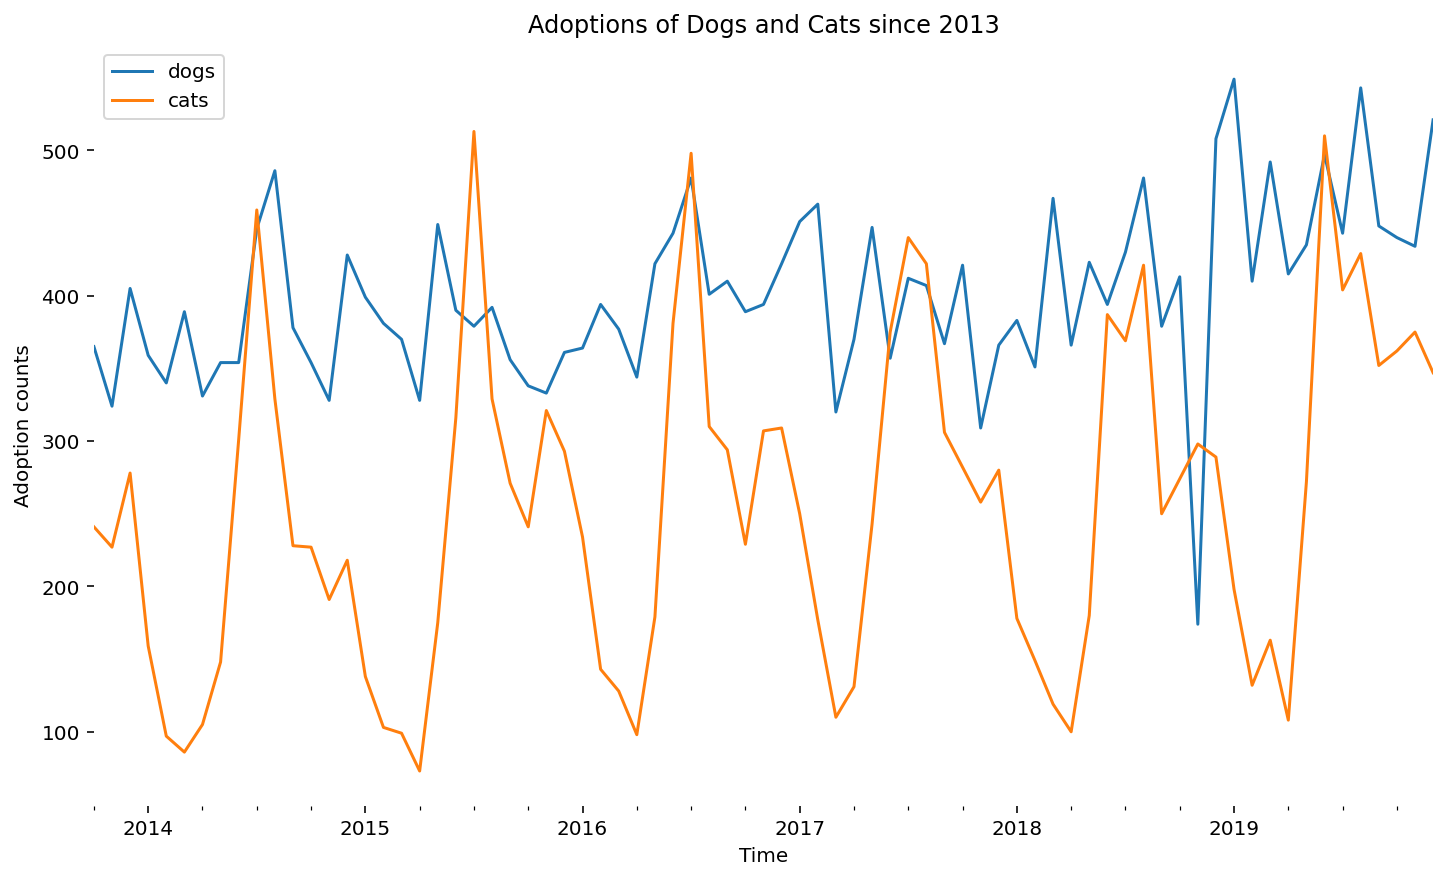

In [17]:
DvCDF = dogsDFGroup[:75].to_frame(name = 'dogs')
DvCDF = DvCDF.assign(cats = catsDFGroup[:75])

TypeVSTime = DvCDF.plot.line(title = "Adoptions of Dogs and Cats since 2013")
plt.ylabel('Adoption counts')
plt.xlabel('Time')
sns.despine(top=True, right=True, left=True, bottom=True)

There is obviously a difference over time between the number of cats and dogs adopted in Austin. Because of this, we will keep them separate for our analyses and models. 

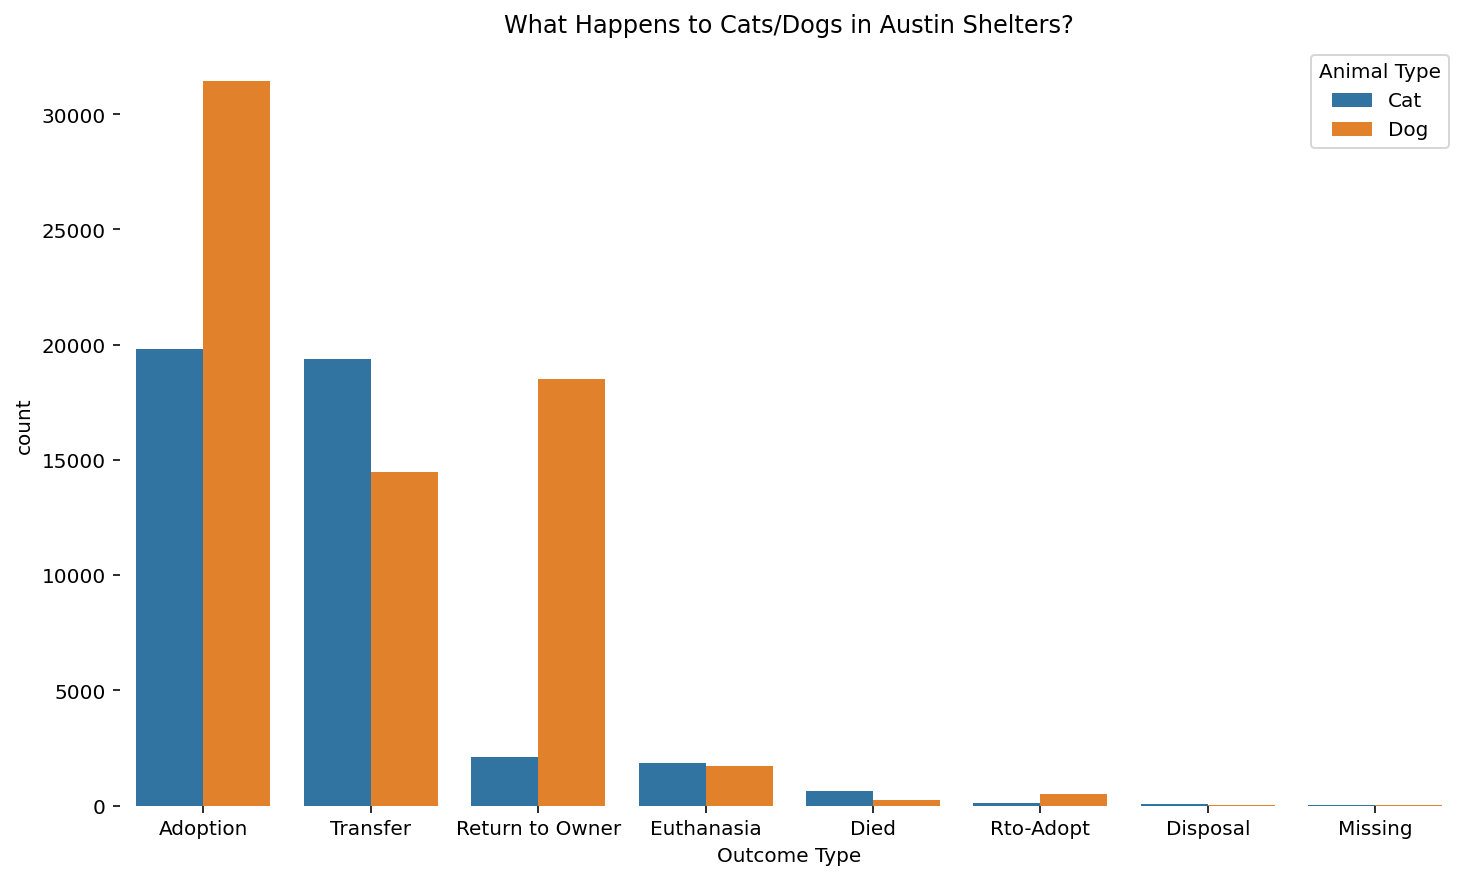

In [18]:
# bar chart - types of outcomes
outcomesOrder = outcomes['Outcome Type'].value_counts(ascending=False).index
sns.countplot(x="Outcome Type", hue="Animal Type", data=outcomes, order=outcomesOrder).set_title('What Happens to Cats/Dogs in Austin Shelters?')
sns.despine(top=True, right=True, left=True, bottom=True)

Text(0.5, 1.0, 'Breed')

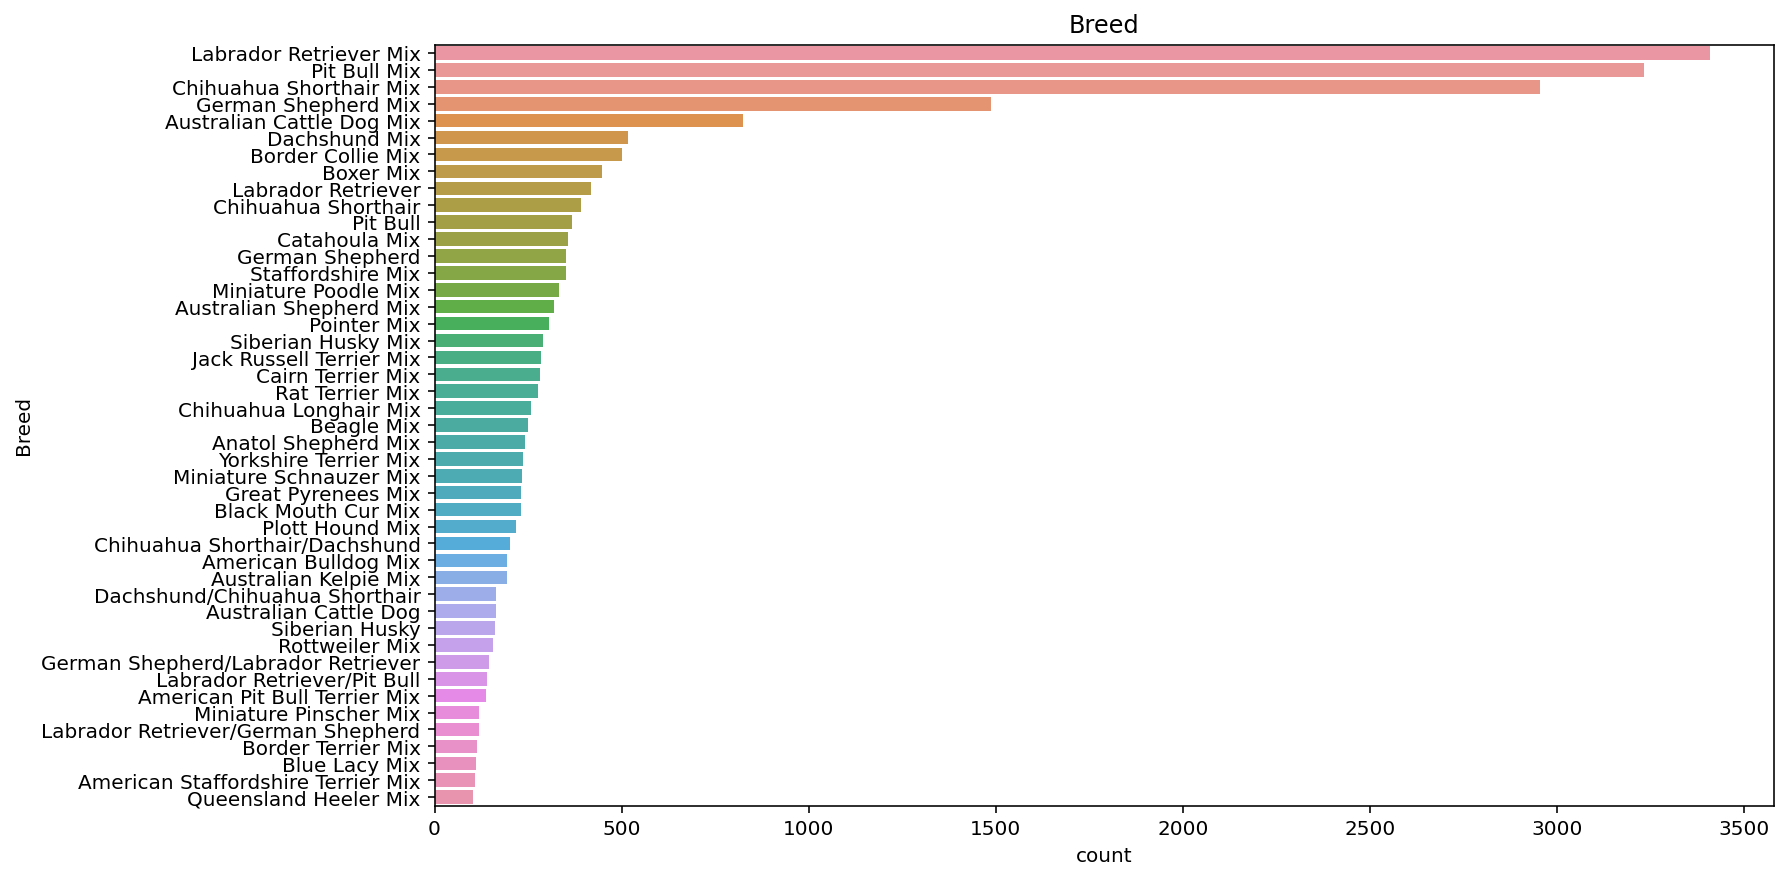

In [19]:
# bar chart - breed because why not break cocalc
breeds = dogsDF['Breed'].value_counts()
breeds = breeds[breeds > 100].index.to_list()
breedsSubset = dogsDF[dogsDF['Breed'].isin(breeds)]

breedOrder = breedsSubset['Breed'].value_counts(ascending=False).index
sns.countplot(y="Breed", data=breedsSubset, order=breedOrder).set_title('Breed')

We can see that in Austin, very few dogs/cats are euthanized. Additionally, The majority of dogs are adopted from shelters, returned home, or transferred to another shelter. Likewise, the vast majority of cats are adopted or transferred to another shelter. 

## Checking Unemployment and Adoption Counts for Normality

In [20]:
#Create unemployment Dataframe and check for normality
unempdf = df[23:].to_numpy()
unempdfArr = []

for i in range(len(unempdf)):
    for j in range(len(unempdf[i])):
        unempdfArr.append(unempdf[i][j])

oneColumn = unempdfArr[9:]

normalTestData = {'unemployment':oneColumn, 'Dogs_adopted':dogsDFGroup[:75], 'Cats_adopted':catsDFGroup[:75]}
ntDF = pd.DataFrame(data=normalTestData)

#Create variables to test for normality
h_unemp = ntDF['unemployment'].values
h_dogadopt = ntDF['Dogs_adopted'].values
h_catadopt = ntDF['Cats_adopted'].values

st_unemp, p_unemp = stats.normaltest(h_unemp)
st_dogadopt, p_dogadopt = stats.normaltest(h_dogadopt)
st_catadopt, p_catadopt = stats.normaltest(h_catadopt)

#Print p values
print('Normal test p-value for unemployment: ' + str(p_unemp))
print('Normal test p-value for monthly dog adoption count: ' + str(p_dogadopt))
print('Normal test p-value for monthly cat adoption count: ' + str(p_catadopt))

#Transform unemployment 
ntDF['unemployment10'] = np.log10(ntDF['unemployment'])

#Test normality on transformed data
h_unemp10 = ntDF['unemployment10'].values
st_unemp10, p_unemp10 = stats.normaltest(h_unemp10)

print('Normal test p-value for unemployment(log transformed): ' + str(p_unemp10))


Normal test p-value for unemployment: 0.0056013896066711075
Normal test p-value for monthly dog adoption count: 0.03902401828974567
Normal test p-value for monthly cat adoption count: 0.17682117508610168
Normal test p-value for unemployment(log transformed): 0.17225962044575818


Text(0, 0.5, 'Count')

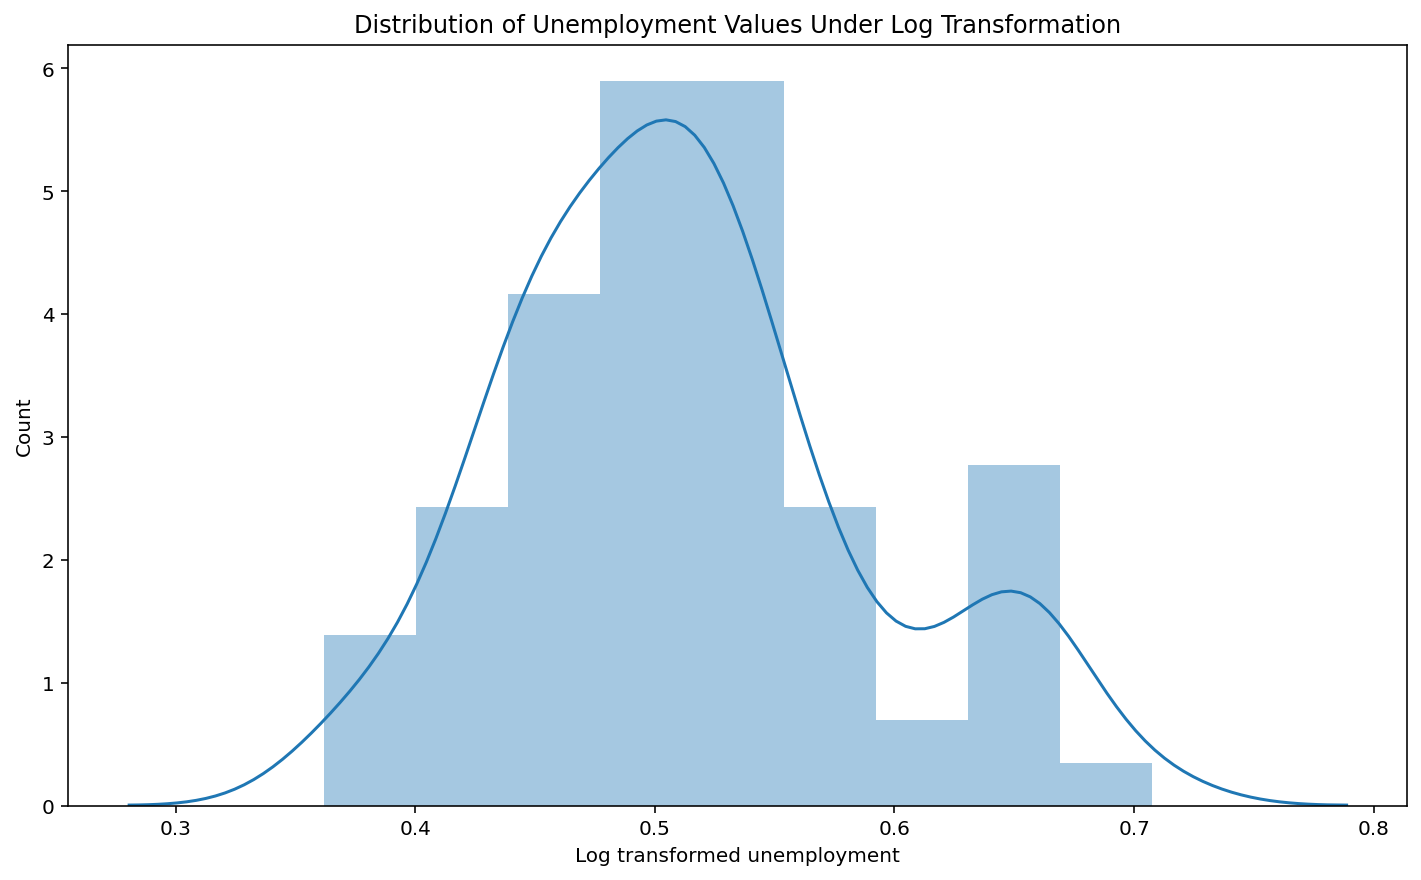

In [21]:
#Print transformed unemployment graph
sns.distplot(ntDF['unemployment10'][ntDF['unemployment'].notnull()],hist=True).set_title('Distribution of Unemployment Values Under Log Transformation')
plt.xlabel("Log transformed unemployment")
plt.ylabel("Count")

We can see that after our transformation, both unemployment rate, dog adoptions, and cat adoptions are normally distributed (given an alpha of 0.01). We will proceed in a model that attempts to predict monthly adoption count from monthly unemployment rate.

## Fitting a Model to Predict Monthly Adoptions from Monthly Unemployment Rate 

Text(0, 0.5, 'Number of dogs Adopted in a Month')

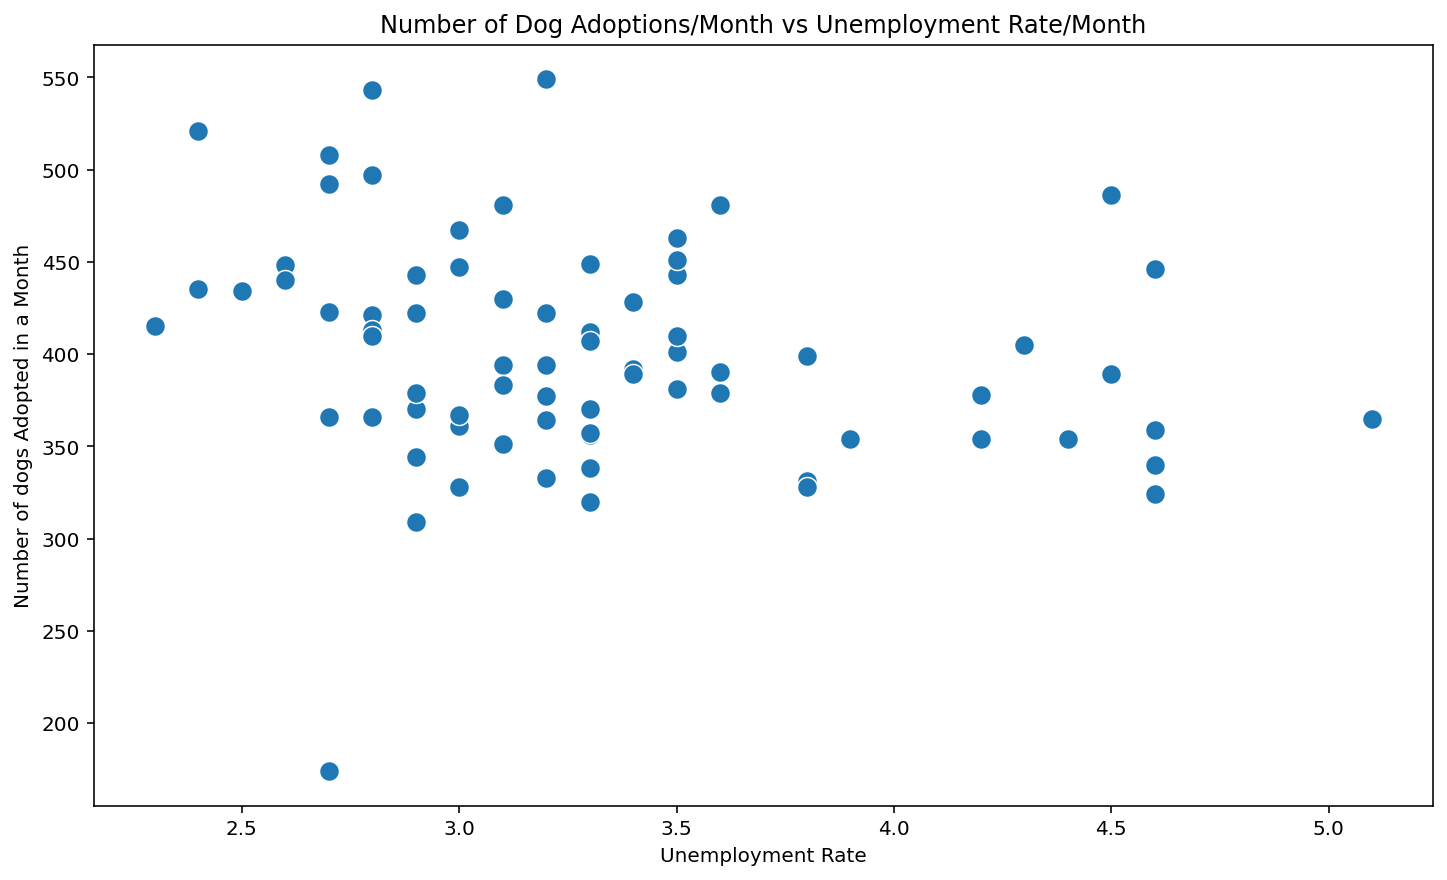

In [22]:
scatterplotData = {'unemployment':oneColumn, 'Dogs_adopted':dogsDFGroup[:75]}
spDF = pd.DataFrame(data=scatterplotData)
sns.scatterplot(x='unemployment', y='Dogs_adopted', data=spDF, s=100).set_title('Number of Dog Adoptions/Month vs Unemployment Rate/Month')
plt.xlabel('Unemployment Rate')
plt.ylabel('Number of dogs Adopted in a Month')
#At a glance there does not appear to be a linear correlation between these two variables

In [23]:
# attempt to fit a model 
spDF['unemployment10'] = np.log10(spDF['unemployment'])
outcomeAdopt, predictorsUnemp = patsy.dmatrices('Dogs_adopted ~ unemployment10', spDF)
mod1 = sm.OLS(outcomeAdopt, predictorsUnemp)
res1 = mod1.fit()
print(res1.summary())
# conclusion: with such a small r squared value we believe that the two variables are not correlated in any way

                            OLS Regression Results                            
Dep. Variable:           Dogs_adopted   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     4.109
Date:                Thu, 11 Jun 2020   Prob (F-statistic):             0.0463
Time:                        05:41:38   Log-Likelihood:                -411.13
No. Observations:                  75   AIC:                             826.3
Df Residuals:                      73   BIC:                             830.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        494.2588     46.710     10.

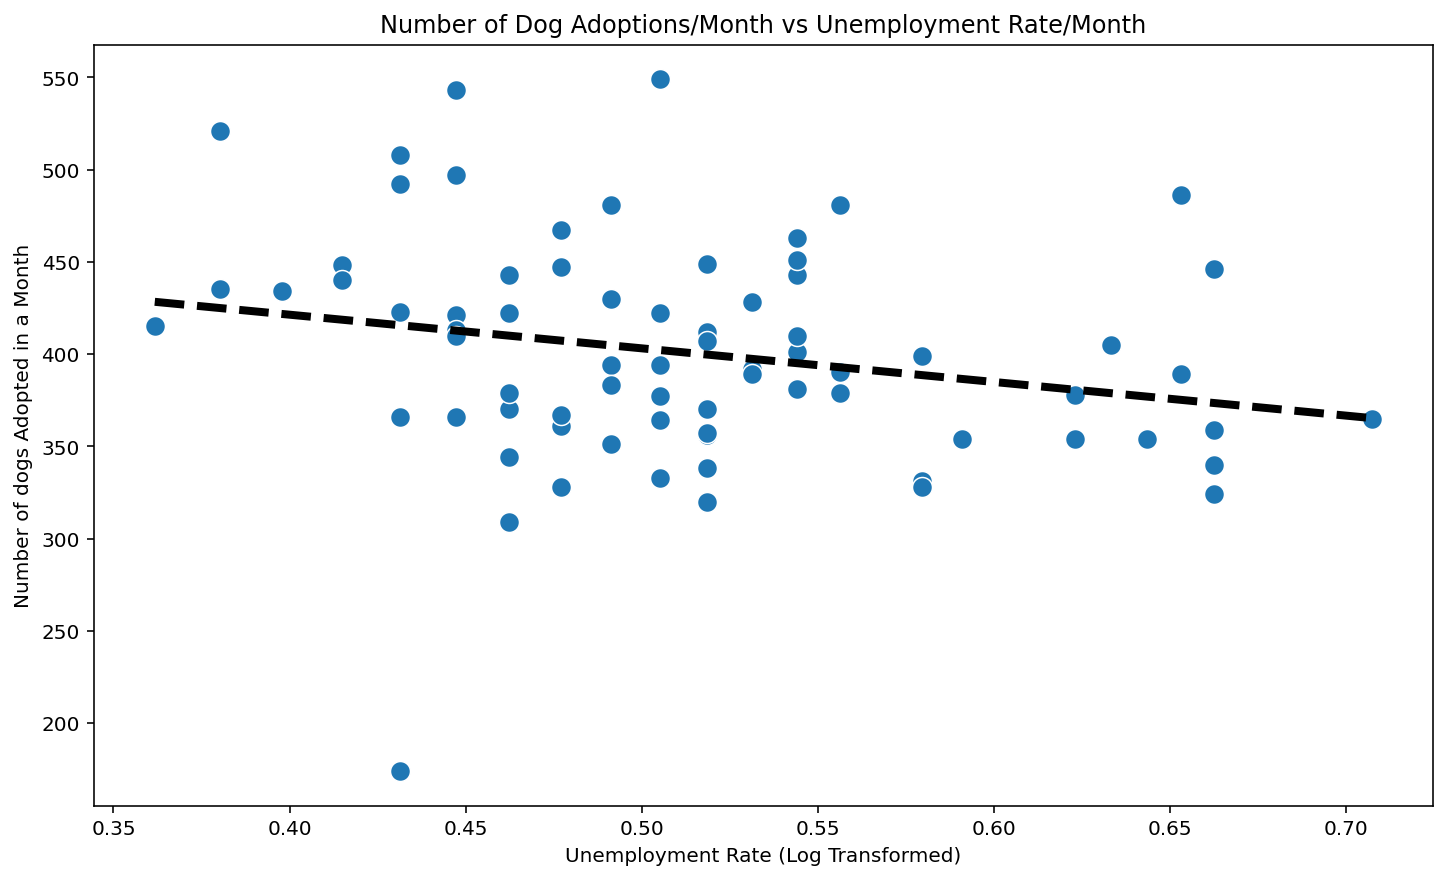

In [24]:
# plot number of dog adoptions per month vs unemployment rate per month.
sns.scatterplot(x='unemployment10', y='Dogs_adopted', data=spDF, s=100).set_title('Number of Dog Adoptions/Month vs Unemployment Rate/Month')
plt.xlabel('Unemployment Rate (Log Transformed)')
plt.ylabel('Number of dogs Adopted in a Month')
xs = np.array([spDF['unemployment10'].min(), spDF['unemployment10'].max()])
ys = -182.3012* xs + 494.2588
plt.plot(xs,ys,'--k',linewidth=4,label='Model')

Visually, it appears that unemployment would explain some of the variance for number of adoptions. However, upon examining the model we can see that our p-value is 0.046 which is greater than our alpha value of 0.01. In addition we see our r square value is very low, leading to an r value of about .23. This is a very weak relationship between the two variables. This means we reject our alternate hypothesis in favor of the null hypothesis and conclude that there is no relationship between unemployment rate and dog adoptions.

Text(0, 0.5, 'Number of Cats Adopted in a Month (Log Transformed)')

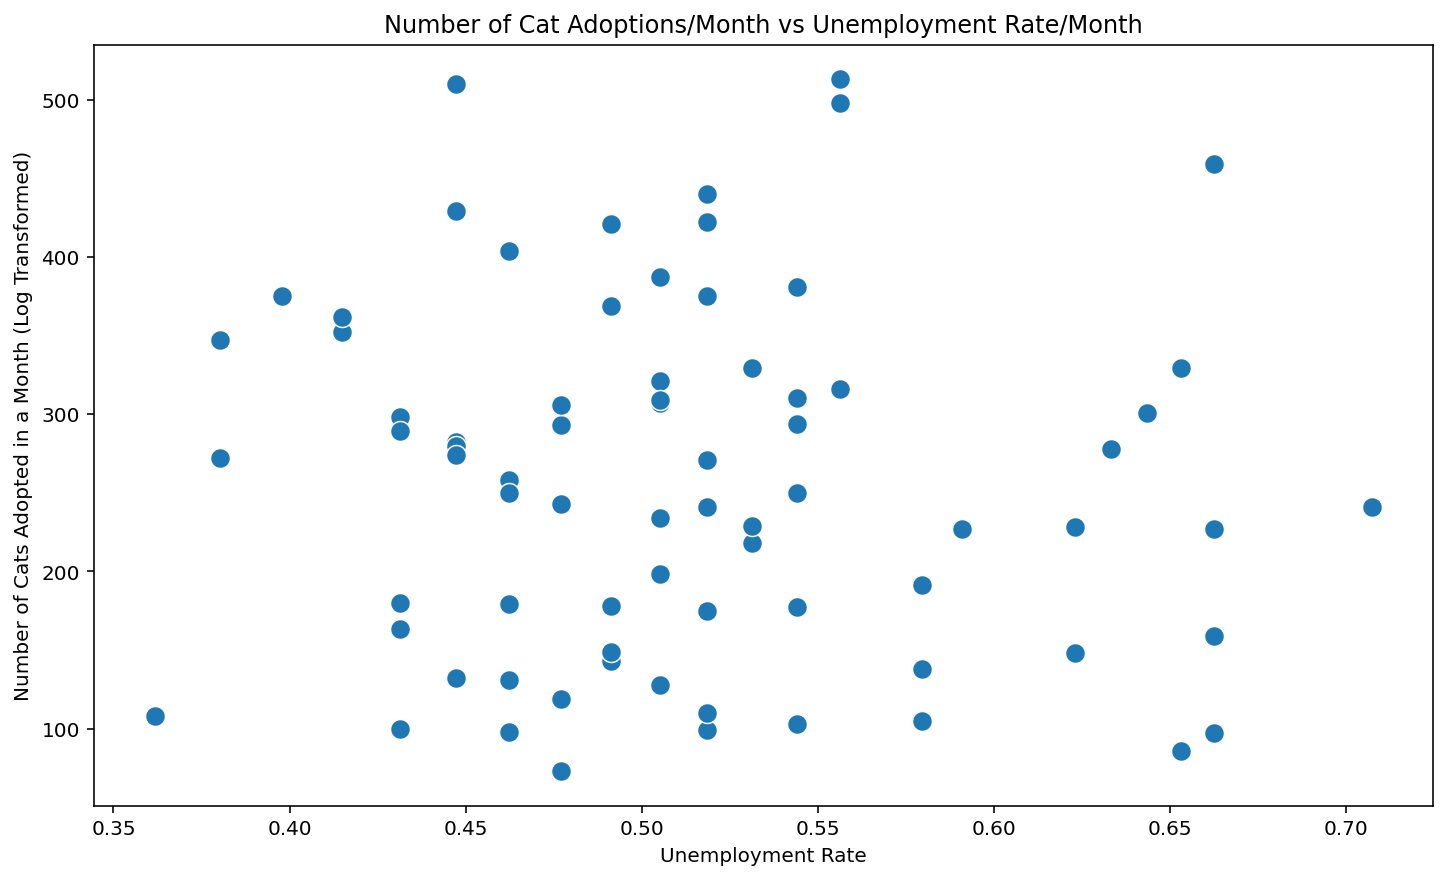

In [25]:
#plot adopted cats per month vs unemployment per month
scatterplotData2 = {'unemployment10':spDF['unemployment10'], 'Cats_adopted':catsDFGroup[:75]}
spDF2 = pd.DataFrame(data=scatterplotData2)
sns.scatterplot(x='unemployment10', y='Cats_adopted', data=spDF2, s=100).set_title('Number of Cat Adoptions/Month vs Unemployment Rate/Month')
plt.xlabel('Unemployment Rate')
plt.ylabel('Number of Cats Adopted in a Month (Log Transformed)')

We see little relationship between unemployment rate and cat adoption, so we will not attempt to fit a model.

## Exploring the **Difference** in Monthly Adoption Count and the **Difference** in Monthly Unemployment Rate
Because we could not generate a very good model directly comparing the number of adopted to the unemployment rate, we will try and examine differences over time to create a model.

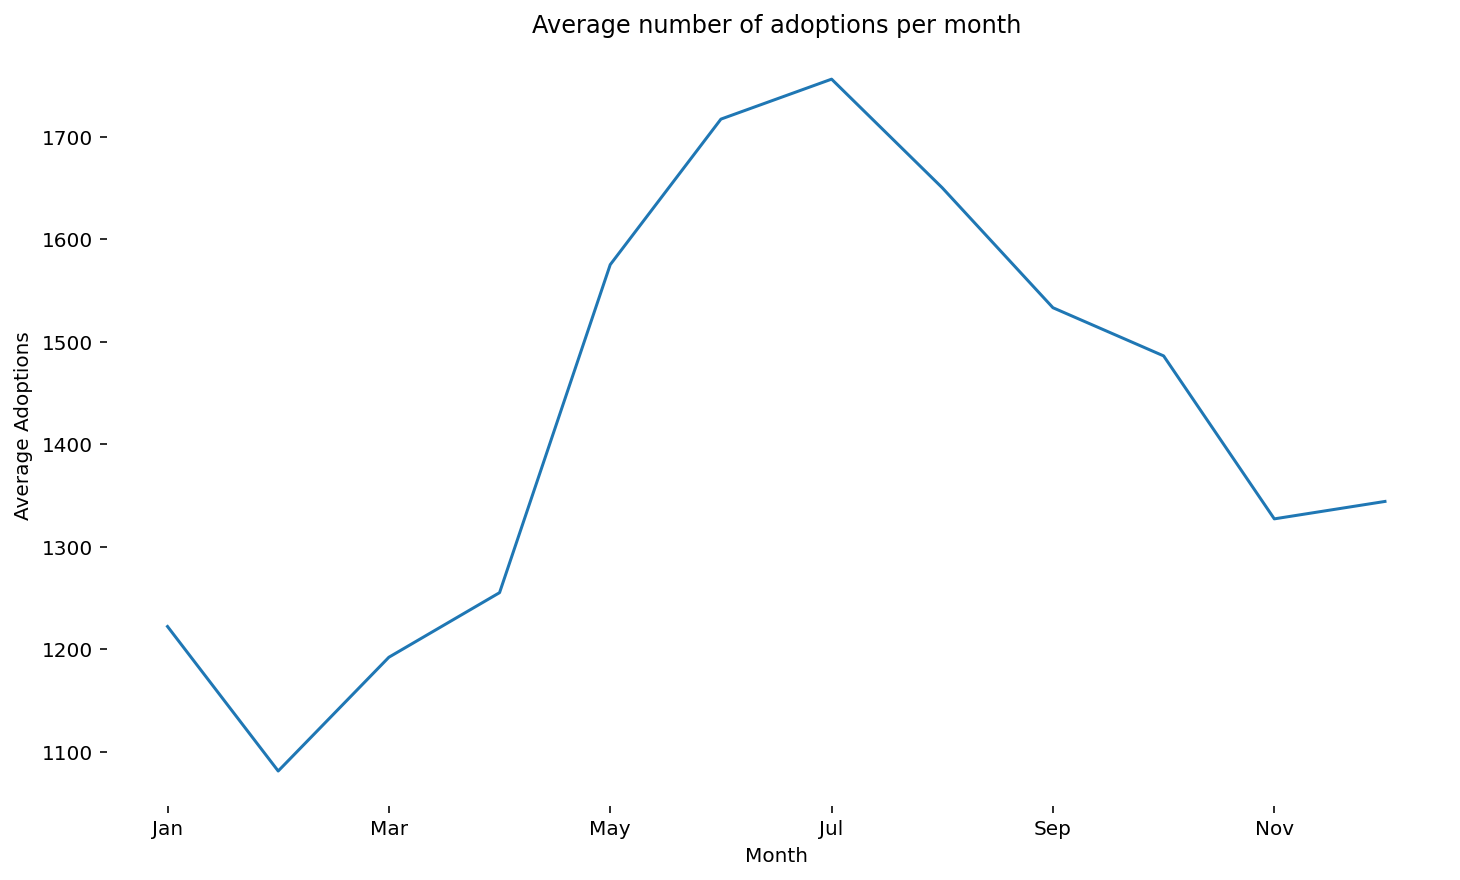

In [26]:
# function to count total number of adoptions in one month over data set
def monthAgg(df):
    # count number of adoptions in each month
    counts = [0,0,0,0,0,0,0,0,0,0,0,0]
    for i in range(len(df.index)):
        if df['month'][i] == 1:
            counts[0] += df['DateTime'][i]
        if df['month'][i] == 2:
            counts[1] += df['DateTime'][i]
        if df['month'][i] == 3:
            counts[2] += df['DateTime'][i]
        if df['month'][i] == 4:
            counts[3] += df['DateTime'][i]
        if df['month'][i] == 5:
            counts[4] += df['DateTime'][i]
        if df['month'][i] == 6:
            counts[5] += df['DateTime'][i]
        if df['month'][i] == 7:
            counts[6] += df['DateTime'][i]
        if df['month'][i] == 8:
            counts[7] += df['DateTime'][i]
        if df['month'][i] == 9:
            counts[8] += df['DateTime'][i]
        if df['month'][i] == 10:
            counts[9] += df['DateTime'][i]
        if df['month'][i] == 11:
            counts[10] += df['DateTime'][i]
        if df['month'][i] == 12:
            counts[11] += df['DateTime'][i]
    return counts

# create a data frame with the adoptions and dates
corr2 = newOutcomesGroup[:75].to_frame()
months2 = corr2.index.month
corr2 = corr2.assign(month = months2)

# use function to find adoptions counts for each month
adoptionAvgPerMonth = monthAgg(corr2)

# find average number of adoptions in each month
monthFreq = corr2['month'].value_counts(ascending = True).to_numpy()
for i in range(len(adoptionAvgPerMonth)):
    adoptionAvgPerMonth[i] = int(adoptionAvgPerMonth[i]/monthFreq[i])
adoptionAvgPerMonth = pd.DataFrame(adoptionAvgPerMonth)

# change index to months
adoptionAvgPerMonth = adoptionAvgPerMonth.rename(columns={0:'Averages'}, index={0:'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sep', 9:'Oct', 10:'Nov', 11:'Dec'})

# plot average number of adoptions over one year to visualize month with highest average adoptions.
adoptionAvgPerMonth.plot(title="Average number of adoptions per month")

# improve plot visualization
plt.xlabel("Month")
plt.ylabel("Average Adoptions")
plt.gca().get_legend().remove()
sns.despine(top=True, right=True, left=True, bottom=True)

Interesting to note from Average Monthly Adoption Numbers is that there is a consistent spike in numbers during the summer months across our 2013-2019 data.

In [27]:
# add unemployment data to the adoptions dataframe
empData = {'unemployment':oneColumn}
empDF = pd.DataFrame(empData)
empDF = empDF.set_index(corr2.index)
corr3 = corr2.assign(unemp = empDF['unemployment'])
corr3 = corr3.rename(columns={'DateTime':'Averages'})

# find change in adoptions and unemployment over time
corr3['Averages'] = corr3['Averages'].diff()
corr3 = corr3.replace(corr3['unemp'], corr3['unemp'].diff())
diffEmp = corr3['unemp'].diff()
diffEmp = pd.DataFrame(diffEmp)
corr6 = diffEmp.assign(Averages=corr3['Averages'])

# use OLS to determine if change in number of adoptions can be predicted using change in unemployment
outcome_1, predictors_1 = patsy.dmatrices('Averages ~ unemp', corr6)
corr3['unemp'] = oneColumn
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:               Averages   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     4.127
Date:                Thu, 11 Jun 2020   Prob (F-statistic):             0.0459
Time:                        05:41:40   Log-Likelihood:                -490.16
No. Observations:                  74   AIC:                             984.3
Df Residuals:                      72   BIC:                             988.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1588     21.697      0.192      0.8

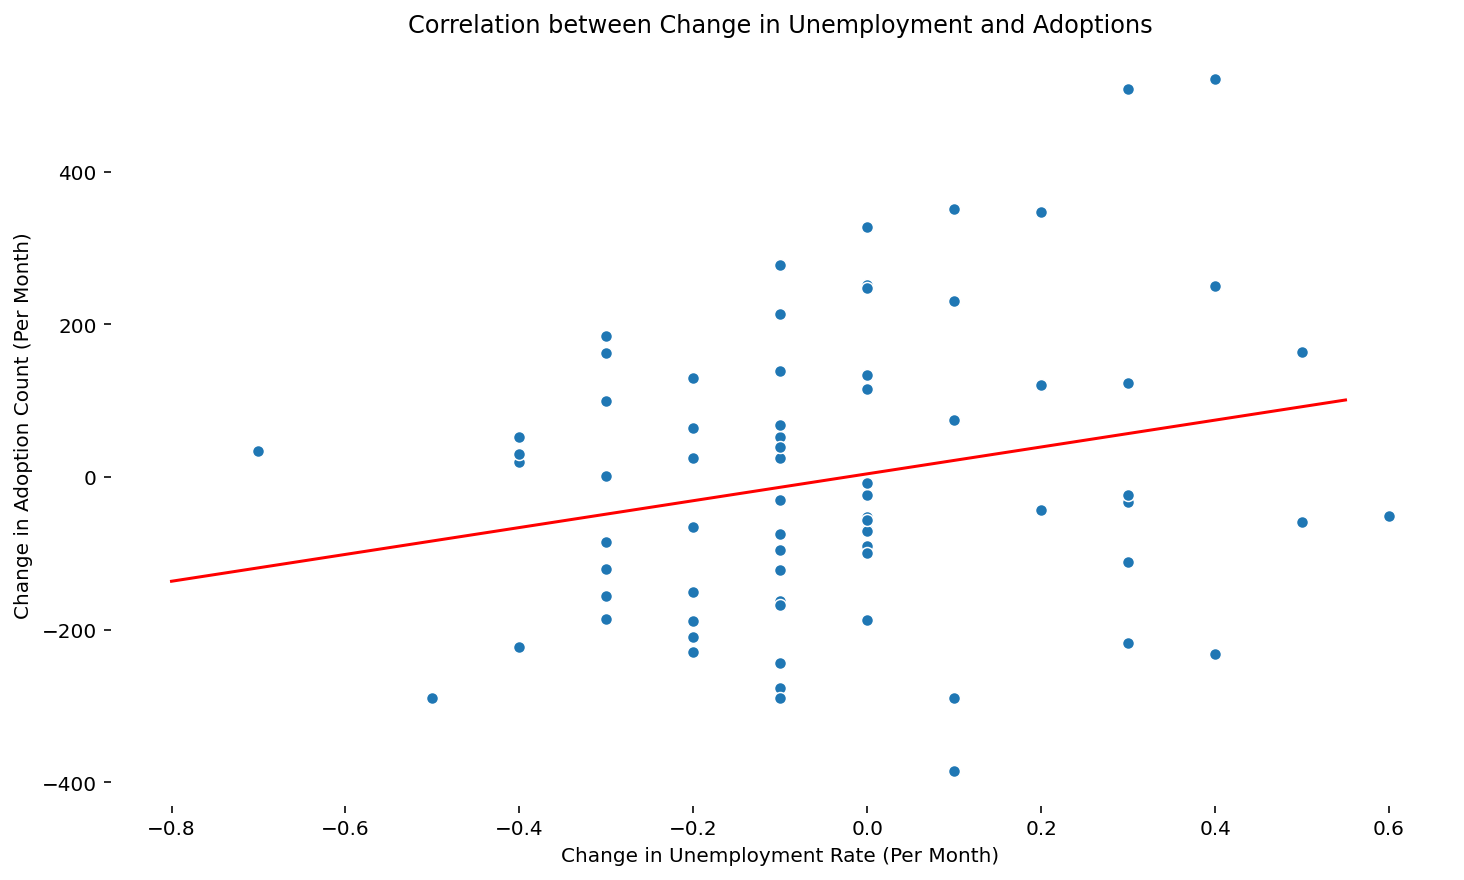

In [28]:
# make a scatter plot of difference in unemployment vs  difference in number of adoptions
sns.scatterplot(x=corr6['unemp'], y=corr6['Averages']).set_title('Correlation between Change in Unemployment and Adoptions')

# plot a predicted trend line using difference in unemployment as predictor
a1, b1 = np.polyfit(corr6['unemp'][1:], corr6['Averages'][1:], 1)
x1 = np.arange(-.8, .6, .05)
y1 = a1*x1+b1

# improve plot visualization
plt.plot(x1,y1,color='r')
plt.xlabel('Change in Unemployment Rate (Per Month)')
plt.ylabel('Change in Adoption Count (Per Month)')
sns.despine(top=True, right=True, left=True, bottom=True)

Since our original model did not show any correlation between the two variables we wanted to be certain that no relationship between the variables exist. We wanted to confirm that our original model was correct by looking at the differences between unemployment rate and differences between adoption rate on a month by month basis. If we have the same results as before we can confirm there is no relationship at all.

Every point in the graph is the change in unemployment and adoption rate on a month by month basis (eg: March 2013 -> April 2013 would be represented by a single point on the graph. The location is determined by the change in unemployment from March to April as well as the change in Adoption for that same time frame).

Unfortunately, this model does not show a strong relationship. We have a very weak positive relationship (r value of ~0.23) between the variables. Our p-value of 0.046 (once again greater than our alpha value of 0.01) rejects the alternative hypothesis in favor of the null hypothesis. We once again conclude that there is no relationship between Dog adoption count and unemployment.

## Exploring the Effect of Age on a Pet's Outcome

Here we will be exploring how age affects the outcome of both cats and dogs. Since there are many more dogs at a younger age compared to those at an older age we cannot use raw number values to determine if younger ages increases the chance of adopting. Instead we will be defining a ratio of adoption to some other outcome (euthanized, transferred, or returned to owner) and seeing if that ratio decreases as the animal age increases.

Normal test p-value for age: 0.0
Normal test p-value for age (log transformed): 0.0


Text(0, 0.5, 'Density')

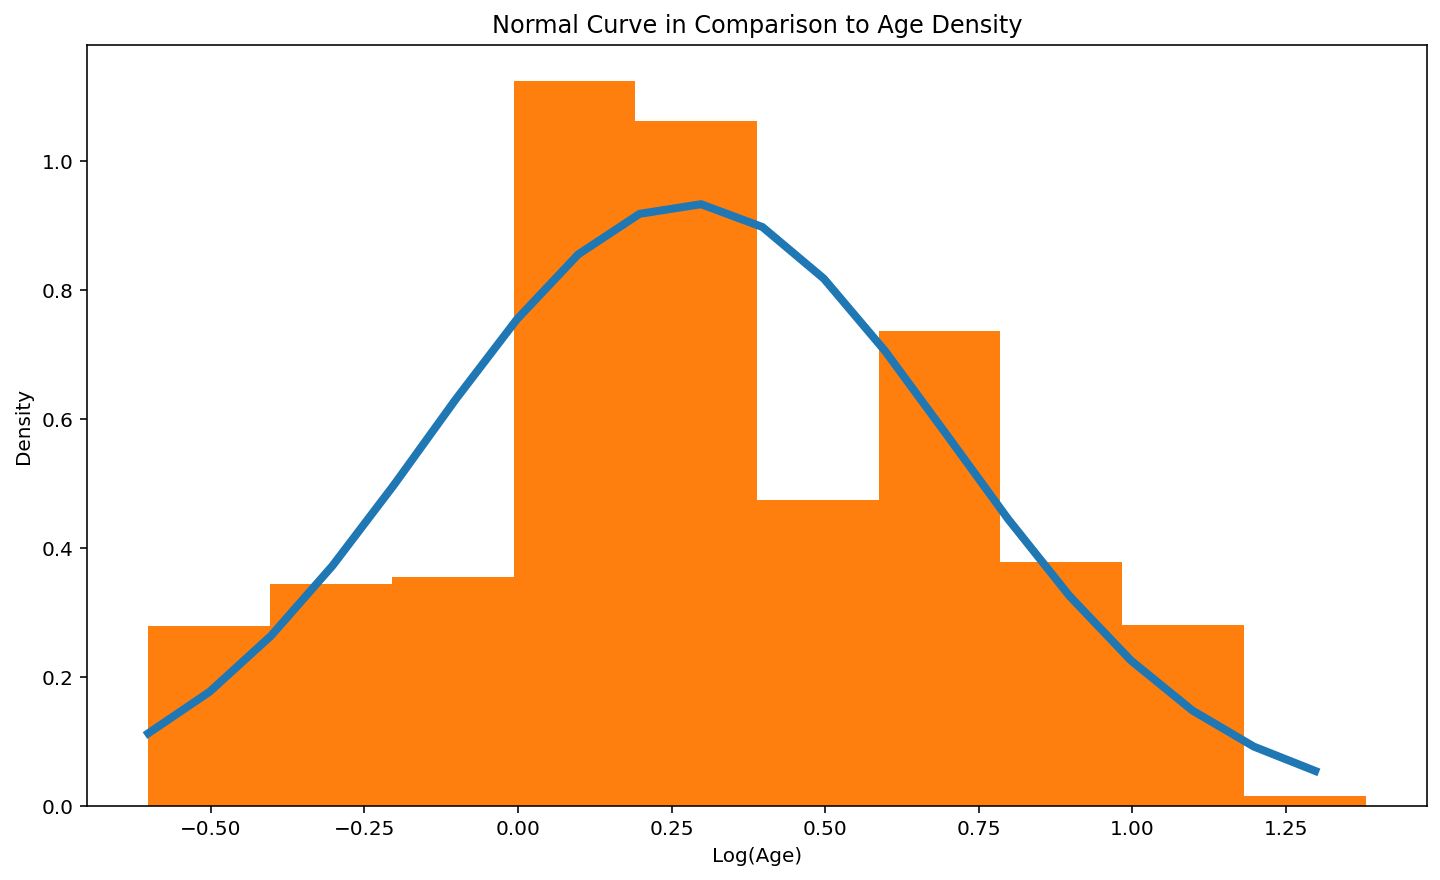

In [29]:
#Create dataframe with only dogs
outcomes['Age_10'] = np.log10(outcomes['Age upon Outcome'])
dogOutcomesDF = outcomes.loc[outcomes['Animal Type'] == "Dog"]

#Test p values
h_age = dogOutcomesDF[dogOutcomesDF['Age upon Outcome'] >= 0.153846]['Age upon Outcome'].values
st_age, p_age = stats.normaltest(h_age)

h_age10 = dogOutcomesDF[dogOutcomesDF['Age_10'] >= -0.76]['Age_10'].values
st_age10, p_age10 = stats.normaltest(h_age10)

# we can see if the log transformation of "Age upon Outcome" is normally distributed
print('Normal test p-value for age: ' + str(p_age))
print('Normal test p-value for age (log transformed): ' + str(p_age10))

#Graph against normal curve
xs = np.arange(h_age10.min(), h_age10.max(), 0.1)
fit = stats.norm.pdf(xs, np.mean(h_age10), np.std(h_age10))
plt.plot(xs, fit, label = 'Normal Dist.', lw = 4)
plt.hist(h_age10, density = True, label = 'Actual Data')
plt.title("Normal Curve in Comparison to Age Density")
plt.xlabel('Log(Age)')
plt.ylabel('Density')

From the p-value of our normal test, we see that the ages are not normally distributed even when transformed. However, we will proceed to fit a model with age as a predictor and later check to see if the residuals are normally distributed. 

Text(0, 0.5, 'Ratio of Dogs adopted')

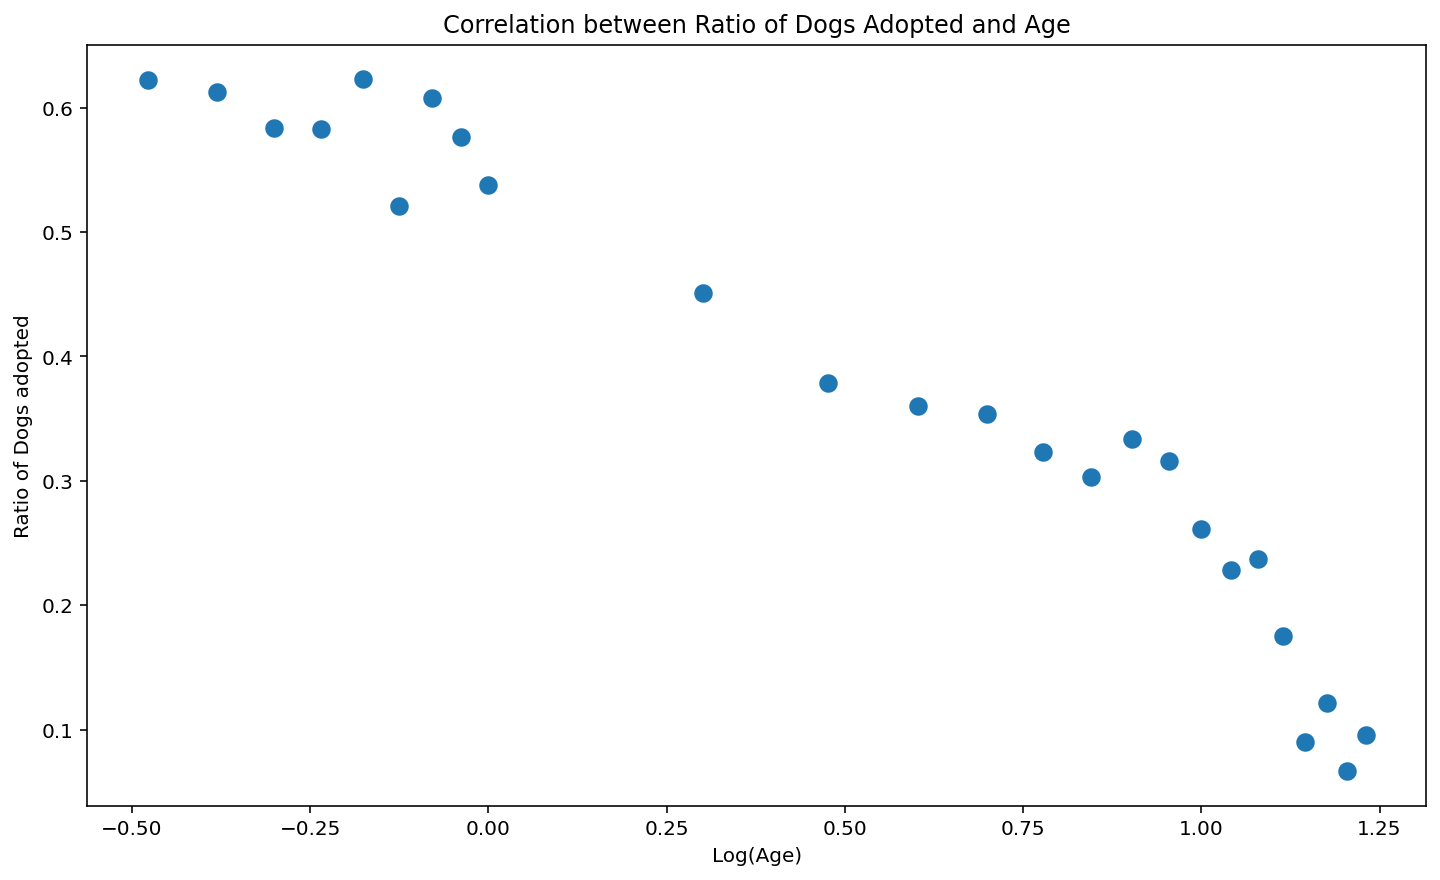

In [30]:
#Get values for outcomes of adoption,transfer,etc
age_adoption = (dogOutcomesDF[dogOutcomesDF['Outcome Type'] == 'Adoption'])['Age_10'].value_counts().sort_index()
age_transfer = (dogOutcomesDF[dogOutcomesDF['Outcome Type'] == 'Transfer'])['Age_10'].value_counts().sort_index()
age_euthanasia = (dogOutcomesDF[dogOutcomesDF['Outcome Type'] == 'Euthanasia'])['Age_10'].value_counts().sort_index()
age_return = (dogOutcomesDF[dogOutcomesDF['Outcome Type'] == 'Return to Owner'])['Age_10'].value_counts().sort_index()

#Create a ratio of adoption:other outcomes
totalratio = age_adoption/(age_return + age_adoption + age_transfer + age_euthanasia)

#Create dataframe with ratio data
ageData = {'Age_10':totalratio.index, 'Animals_adopted':totalratio.values}
ageDataFrame = pd.DataFrame(data=ageData)
ageDataFrame = ageDataFrame.dropna()
ageDataFrame = ageDataFrame[5:]

#Plot graph
sns.scatterplot(x='Age_10', y='Animals_adopted', data=ageDataFrame, s=100).set_title("Correlation between Ratio of Dogs Adopted and Age")
plt.xlabel('Log(Age)')
plt.ylabel('Ratio of Dogs adopted')
#make sure we explain why we dropped the first 4 in the writeup

In graphing the above relationship, we left out the first few values of age. This is because they represent extreme outliers where the dogs were aged only a few days old. These dogs are too young to be adopted and likely represent an entry error or irregular situation. 

In [31]:
#Get regression results
outcomeAdopt2, predictorsAge = patsy.dmatrices('Animals_adopted ~ Age_10', ageDataFrame)
mod2 = sm.OLS(outcomeAdopt2, predictorsAge)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:        Animals_adopted   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     321.4
Date:                Thu, 11 Jun 2020   Prob (F-statistic):           5.17e-15
Time:                        05:41:42   Log-Likelihood:                 40.774
No. Observations:                  25   AIC:                            -77.55
Df Residuals:                      23   BIC:                            -75.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5296      0.013     40.319      0.0

From the regression results above we see a very strong correlation between the two variables. We obtain a p value of less than 0.01 which means we reject our null hypothesis (That there is no relationship between age and adoption rate) in favor of the alternative hypothesis.

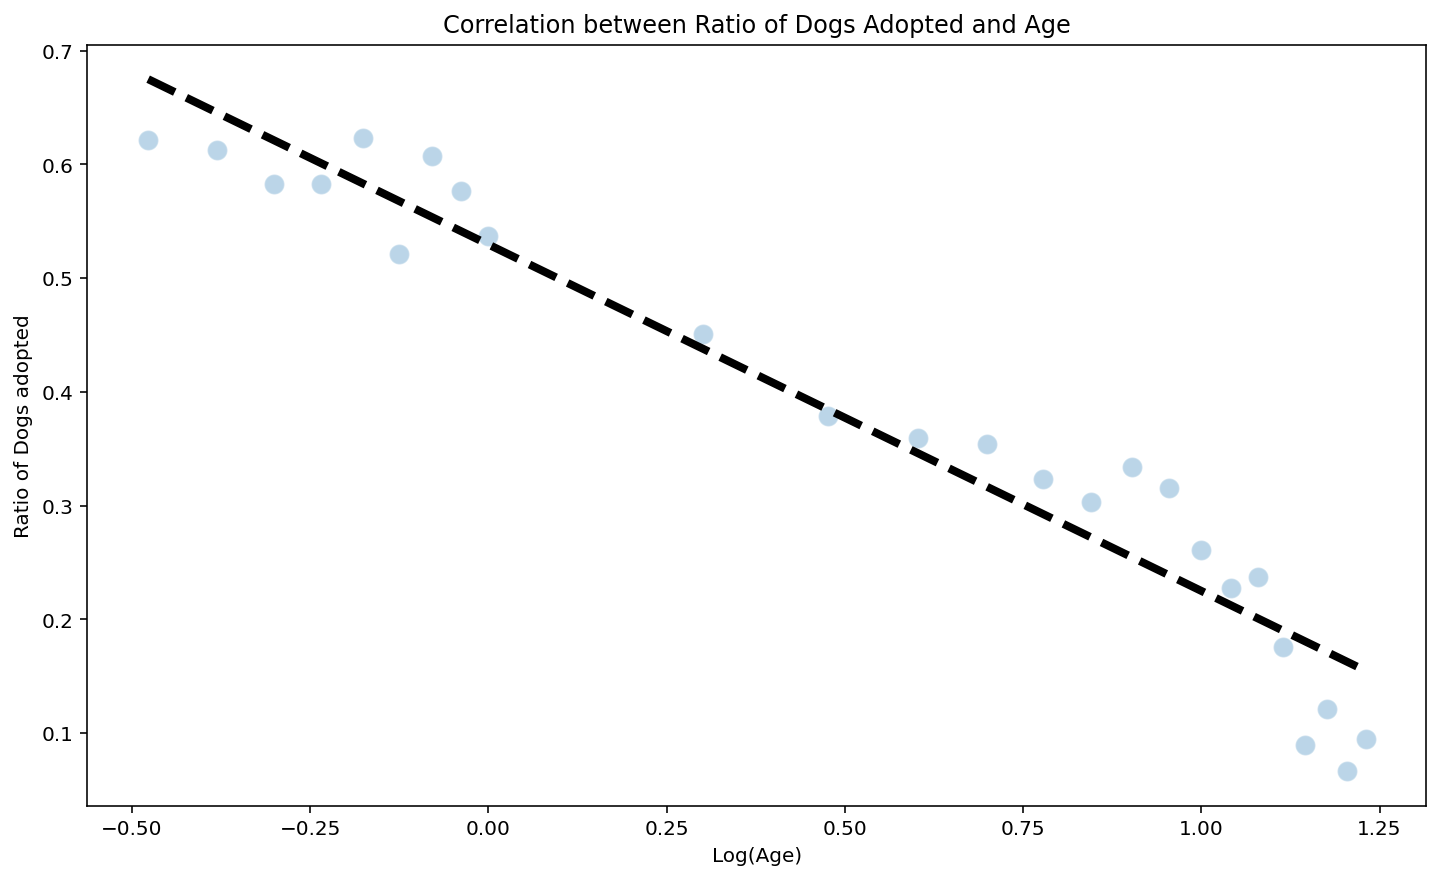

In [32]:
#Plot best fit line
sns.scatterplot(x='Age_10', y='Animals_adopted', alpha=0.3, data=ageDataFrame, s=100).set_title("Correlation between Ratio of Dogs Adopted and Age")
plt.xlabel('Log(Age)')
plt.ylabel('Ratio of Dogs adopted')
xs= np.array([ageDataFrame['Age_10'].min(), ageDataFrame['Age_10'].max()])
ys = -0.3046 * xs + 0.5296
plt.plot(xs,ys,'--k',linewidth=4,label='Model')

In [33]:
#Ensure the residuals are normalized
results = sm1.ols(formula='Animals_adopted ~ Age_10', data=ageDataFrame).fit()
Y_pred = results.predict(ageDataFrame[["Age_10"]])
residual = ageDataFrame["Animals_adopted"].values-Y_pred
st_resid, p_resid = stats.normaltest(residual)
print('Normal test P value: ' + str(p_resid))

Normal test P value: 0.5470464938061609


Here we plot our best fit line and get the residuals. Once obtained we check to see if these values are normalized or not. Since they are we have reason to believe that with the data used above that there is a negative linear relationship between age and the ratio of dogs adopted.

Normal test p-value for age: 0.0
Normal test p-value for age (log transformed): 0.0


Text(0, 0.5, 'Density')

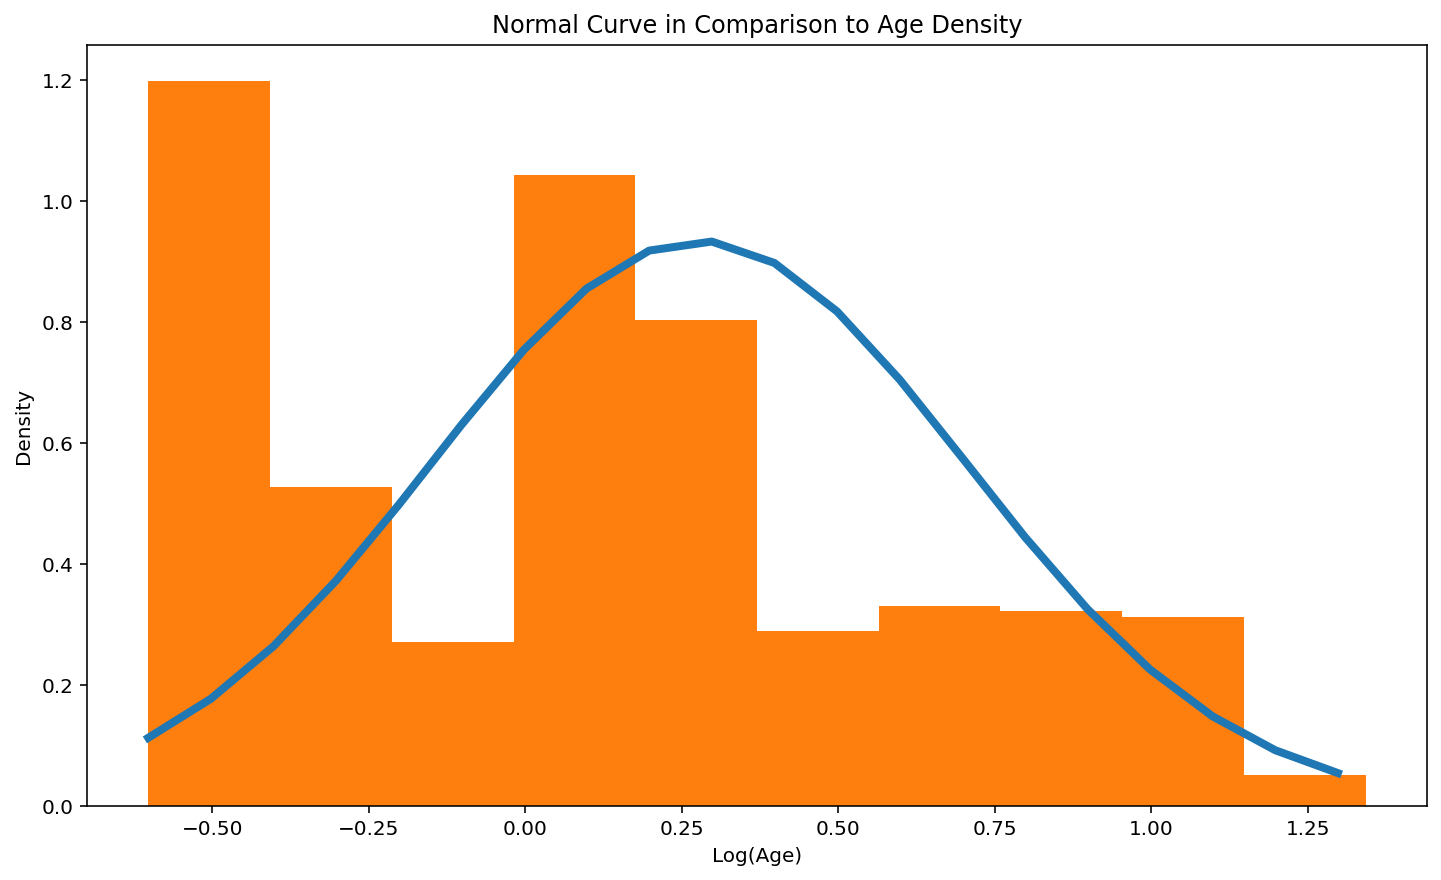

In [34]:
#Do the same thing for cats
#Create dataframe with only dogs
outcomes['Age_10'] = np.log10(outcomes['Age upon Outcome'])
catOutcomesDF = outcomes.loc[outcomes['Animal Type'] == "Cat"]

#Get P value
h_ageC = catOutcomesDF[catOutcomesDF['Age upon Outcome'] >= 0.153846]['Age upon Outcome'].values
st_ageC, p_ageC = stats.normaltest(h_ageC)

h_age10C = catOutcomesDF[catOutcomesDF['Age_10'] >= -0.76]['Age_10'].values
st_age10C, p_age10C = stats.normaltest(h_age10C)

# we can see if the log transformation of "Age upon Outcome" is normally distributed
print('Normal test p-value for age: ' + str(p_ageC))
print('Normal test p-value for age (log transformed): ' + str(p_age10C))

#Graph against normal curve
xs2 = np.arange(h_age10C.min(), h_age10C.max(), 0.1)
fit2 = stats.norm.pdf(xs, np.mean(h_age10C), np.std(h_age10C))
plt.plot(xs2, fit, label = 'Normal Dist.', lw = 4)
plt.hist(h_age10C, density = True, label = 'Actual Data')
plt.title("Normal Curve in Comparison to Age Density")
plt.xlabel('Log(Age)')
plt.ylabel('Density')

We repeat the process once again for cats. We notice here that the Cat data is very skewed even when transformed, so we will have to proceed with caution and possibly some limitations.

Text(0, 0.5, 'Ratio of Cats adopted')

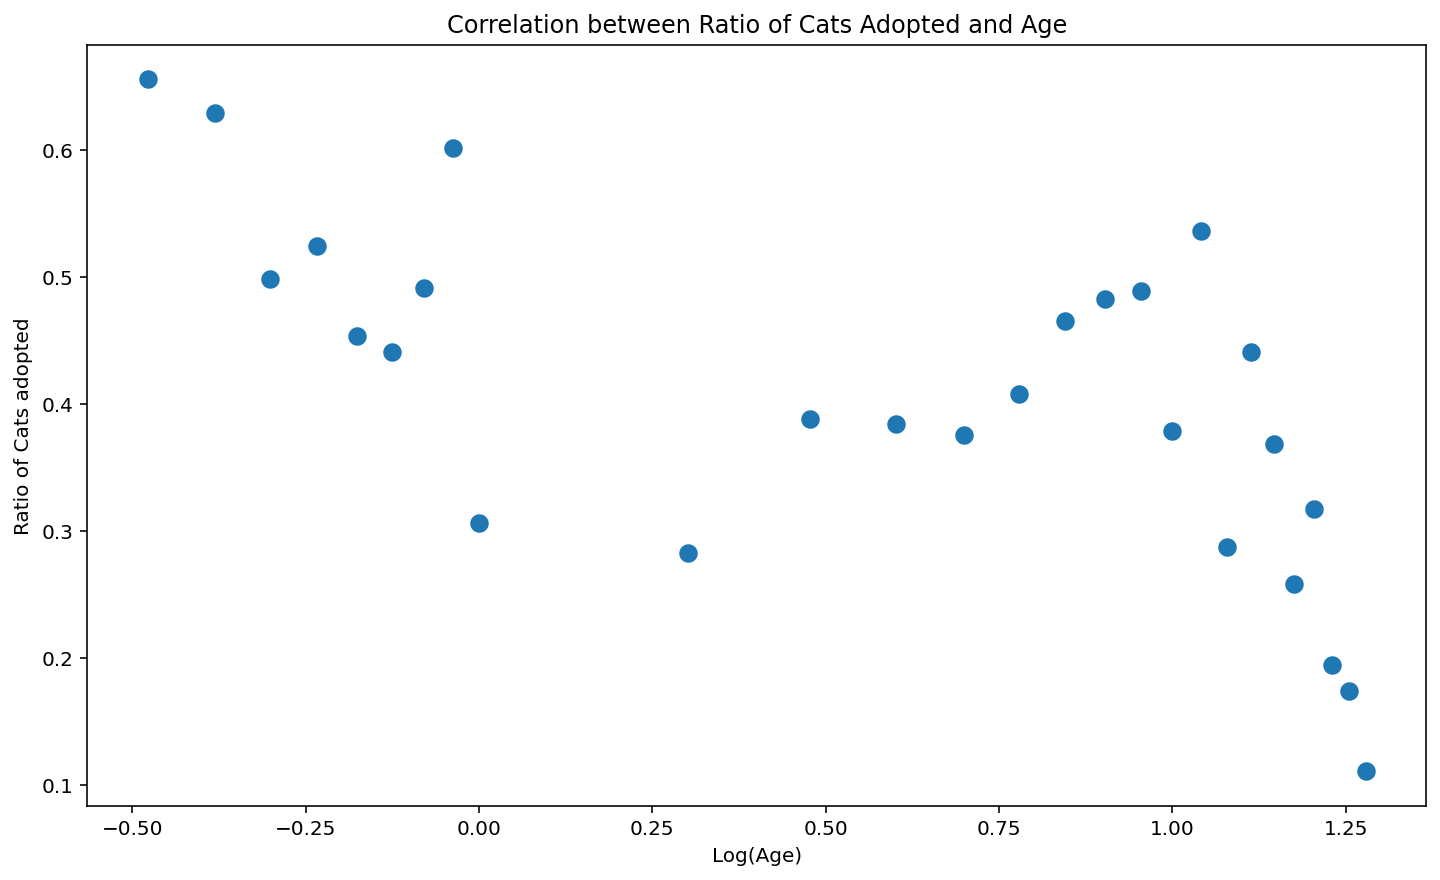

In [35]:
#Get values for outcomes of adoption,transfer,etc
age_adoption2 = (catOutcomesDF[catOutcomesDF['Outcome Type'] == 'Adoption'])['Age_10'].value_counts().sort_index()
age_transfer2 = (catOutcomesDF[catOutcomesDF['Outcome Type'] == 'Transfer'])['Age_10'].value_counts().sort_index()
age_euthanasia2 = (catOutcomesDF[catOutcomesDF['Outcome Type'] == 'Euthanasia'])['Age_10'].value_counts().sort_index()
age_return2 = (catOutcomesDF[catOutcomesDF['Outcome Type'] == 'Return to Owner'])['Age_10'].value_counts().sort_index()

#Create a ratio of adoption:other outcomes
totalratio2 = age_adoption2/(age_return2 + age_adoption2 + age_transfer2 + age_euthanasia2)

#Create a dataframe with ratio data
ageData2 = {'Age_10':totalratio2.index, 'Animals_adopted':totalratio2.values}
ageDataFrame2 = pd.DataFrame(data=ageData2)
ageDataFrame2 = ageDataFrame2.dropna()
ageDataFrame2 = ageDataFrame2[5:]

#Plot graph
sns.scatterplot(x='Age_10', y='Animals_adopted', data=ageDataFrame2, s=100).set_title("Correlation between Ratio of Cats Adopted and Age")
plt.xlabel('Log(Age)')
plt.ylabel('Ratio of Cats adopted')

Once again we notice a downwards trend between age and ratio. However this trend is not a clear as it was for dogs.

In [36]:
#Get regression results
outcomeAdopt3, predictorsAge2 = patsy.dmatrices('Animals_adopted ~ Age_10', ageDataFrame2)
mod3 = sm.OLS(outcomeAdopt3, predictorsAge2)
res3 = mod3.fit()
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:        Animals_adopted   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     18.57
Date:                Thu, 11 Jun 2020   Prob (F-statistic):           0.000224
Time:                        05:41:44   Log-Likelihood:                 23.677
No. Observations:                  27   AIC:                            -43.35
Df Residuals:                      25   BIC:                            -40.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4881      0.028     17.545      0.0

After testing the results once again we see that the relationship between the two variables is not as strong as it was compared to dogs, barring only a roughly .65 r value. This could possibly be due to the data being non-normal when we started testing. Looking past that, we once again see that we have a p value of less than 0.01 and we reject our null hypothesis (that there is no relationship between the two variables) in favor of the alternative.

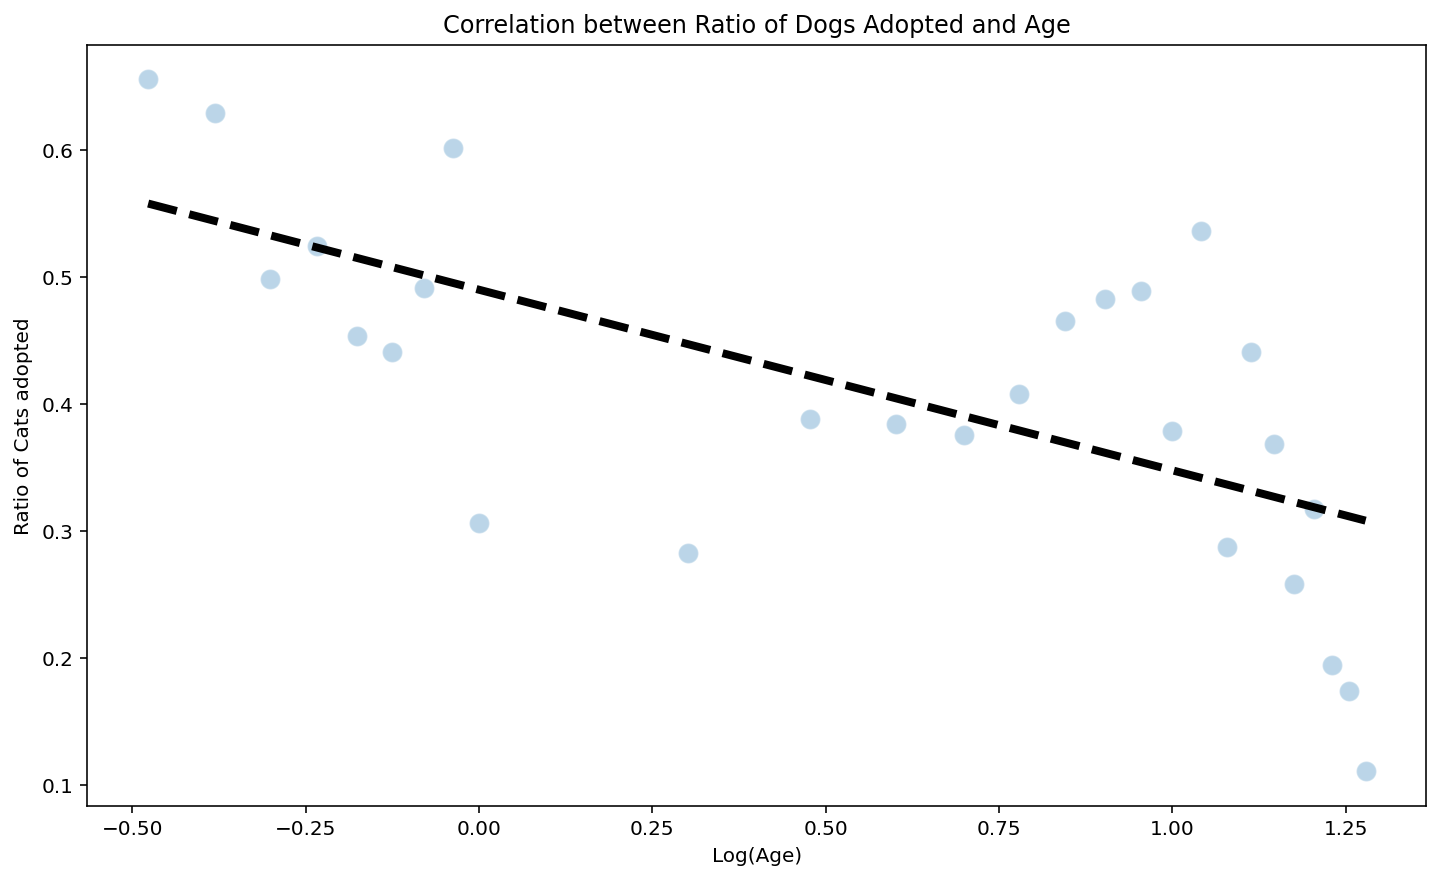

In [37]:
#Plot best fit line
sns.scatterplot(x='Age_10', y='Animals_adopted', alpha=0.3, data=ageDataFrame2, s=100).set_title("Correlation between Ratio of Dogs Adopted and Age")
plt.xlabel('Log(Age)')
plt.ylabel('Ratio of Cats adopted')
xs2 = np.array([ageDataFrame2['Age_10'].min(), ageDataFrame2['Age_10'].max()])
ys2 = -0.1462 * xs + 0.4881
plt.plot(xs2,ys2,'--k',linewidth=4,label='Model')

In [38]:
#Ensure residuals are normal
results2 = sm1.ols(formula='Animals_adopted ~ Age_10', data=ageDataFrame2).fit()
Y_pred2 = results2.predict(ageDataFrame2[["Age_10"]])
residual2 = ageDataFrame2["Animals_adopted"].values-Y_pred2
st_resid2, p_resid2 = stats.normaltest(residual2)
print('Normal test P value: ' + str(p_resid2))

Normal test P value: 0.7915837948722175


Once again we plot the best fit line and get the residuals so we can test normality. Since the pvalue we get is greater than 0.01 we can conclude that the residuals are normally distributed and that the data above is valid.

# Ethics & Privacy

All of the datasets used in this project come from public websites such as the U.S. Bureau of Labor Statistics and data.austintexas.gov. These websites are official data portals that provide datasets that are available to the public to be used for research. As no personal information could be accessed by these datasets, there should be no privacy concerns. We assured to comply with any terms stated by both websites with regards to their privacy policies.

For the pet adoption dataset, there is no identifications of people who adopted or gave up any pets thus their identity will remain anonymous. Pet owners should have given informed consent that their data would be publicly disclosed. The data should come from an unbiased source, but one bias that could potentially affect our data is if pet owners did not give consent to make their adoption/abandonment data publicly available. There are no identifying attributes to risk revealing personal information about individuals. Despite this, we still removed the animal names in the unlikely case they would be unique enough to identify the owner. In the unemployment dataset there are also no identifying attributes to risk revealing personal information of individuals.

An ethical concern we have about the data and our study is that the inverse of our intentions could be realized. Although we hope to understand the factors that impact adoption in order to help shelters connect animals with new homes and properly manage their resources, we acknowledge that the data could empower them to make inhumane decisions. The models could be used to find the ideal times for euthanasia by looking at downturns in adoptions. This is unlikely to happen in Austin, as our data clearly shows the majority of animals are adopted, but if generalized it could provide such information.

# Conclusion

Before we began this project, we found a plethora of news articles on how animal shelters across America were being completely emptied out. The COVID-19 pandemic has surfaced strange behaviors that we have never seen from people, but we thought this pattern of behavior might have been going on even before the virus. We hypothesized that since the glooming effect of the virus has led people to look for comfort in their pets, they would do the same if an event of similar detriment occurred around them. We chose to use unemployment rates to indicate the amount of financial hardship experienced by the average person in Austin, Texas. However, looking through the results of our analyses reveals that our hypothesis was wrong. Our model that tried to predict adoption count based on unemployment rate proved to show a weak relationship. Even after adjusting and trying different approaches, we reached the same conclusion.

We still thought it was important to determine whether an animal may or may not be adopted in order to determine whether there are enough resources to support it long enough to be adopted. Although our initial hypothesis didn't turn out to be correct, we found that age had a significant effect on whether a pet was adopted or not. We also noticed there there was a sharp spike in adoptions on average during the summer months (June and July) and a decrease in adoptions in the winter (January and February). These findings cannot yet be generalized because we were limited by the location of the shelter we chose. Some data covering shelter outcomes for the entire Unites States cost over 500 USD, whereas the Austin, TX data was completely free and publicly available. Our findings imply that the most adoptable pets are very young and adopted during the summer. 

Another factor we thought was important was how the number of adopted pets relate to those that faced different outcomes (euthanasia, transfer, etc). We found no correlation with euthanized pets and adoption numbers, so a decrease in adoptions does not seem to cause a subsequent rise in euthanized pets. For shelters this means that their resources should be saved for winter months and push for adoptions during the summer or when they have young pets. We also investigated correlations to the ratio of adopted and other outcomes. Unemployment rate did not correlate to this ratio, but the age of the pet upon adoption had a significant relationship to this ratio, especially when considering dogs.

Looking at the basis for our first hypothesis, there must have been other indicators we could have used other than unemployment that could predict the trend of adoption rates in Austin, Texas. We did not think of the idea that purchasing a pet and adding on more responsibilities as a person with crippling financial hardship might not be a realistic outcome. Another possibility would be that this pandemic was just a very unique circumstance and does not reflect the regular pattern of behavior of people in Austin, Texas.

# Team Contributions

* Matthew Morgan - Data analysis, conclusion, visualization, overview
* Nicolas La Polla - Data analysis, cleaning, background
* Nathan Price - Data analysis, visualization, cleaning/processing
* Joshua Suh -  Data Analysis, cleaning, Conclusion/Discussion, Background,
* Noemi Yepez - Data analysis, cleaning, Ethics & Privacy
